In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.utils.data

import matplotlib.pyplot as pp
%matplotlib inline

from tqdm import tqdm_notebook as tqdm

from copy import deepcopy

In [3]:
dim = 1000
radius = 2
x_ = torch.cat(
    (
        torch.linspace(start=-2 * radius, end=2 * radius, steps=dim).unsqueeze(1).unsqueeze(1).repeat(1, dim, 1),
        torch.linspace(start=-2 * radius, end=2 * radius, steps=dim).unsqueeze(1).unsqueeze(1).repeat(1, dim, 1).transpose(0, 1)
    ), dim=2
)
y_ = (
    torch.lt(torch.norm(x_, p=2, dim=2), 1).float() + 
    torch.gt(torch.norm(x_, p=2, dim=2), 2).float()
)

In [4]:
def upload(x):
        return x.cuda()

class CircleDataset(torch.utils.data.Dataset):
    def __init__(self, size):
        self.size = size

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        x = torch.rand(2) * 4 * radius - 2 * radius
        y = (
            torch.lt(torch.norm(x, p=2, dim=0, keepdim=True), 1).float() + 
            torch.gt(torch.norm(x, p=2, dim=0, keepdim=True), 2).float()
        )
        x_reg = torch.rand(16, 2) * 4 * radius - 2 * radius
        return x, y, x_reg

dataloader = torch.utils.data.DataLoader(
    dataset=CircleDataset(size=2 ** 20), batch_size=64, shuffle=False
)

In [5]:
def gradient_norm(f, x):
    gradients = autograd.grad(
        outputs=f(x.requires_grad_(True)),
        inputs=x.requires_grad_(True),
        grad_outputs=torch.ones_like(f(x.requires_grad_(True))),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradient_norm = torch.norm(gradients, p=2, dim=1, keepdim=True)
    return gradient_norm

def visualize(x, vmin, vmax):
    print(f"visualize range [{x.min().item()}, {x.max().item()}] mean {x.mean().item()}")
    pp.figure(num=None, figsize=(12, 12), dpi=80)
    fig = pp.imshow(
        x, cmap='hot', interpolation='nearest', 
        extent=(-2 * radius, 2 * radius, -2 * radius, 2 * radius), vmin=vmin, vmax=vmax
    )
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    pp.show()

def visualize_map(f):
    visualize(
        f(x_.view(dim**2, 2).cuda()).detach().cpu().view(dim, dim).flip(0),
        vmin=0, vmax=1
    )

def visualize_error(f):
    visualize(
        torch.abs(f(x_.view(dim**2, 2).cuda()).detach().cpu().view(dim, dim) - y_).flip(0),
        vmin=0, vmax=1
    )

def visualize_gradients(f):
    visualize(
        gradient_norm(f=f, x=x_.view(dim**2, 2).cuda()).detach().cpu().view(dim, dim).flip(0),
        vmin=0, vmax=1
    )

visualize range [0.0, 1.0] mean 0.8530200123786926


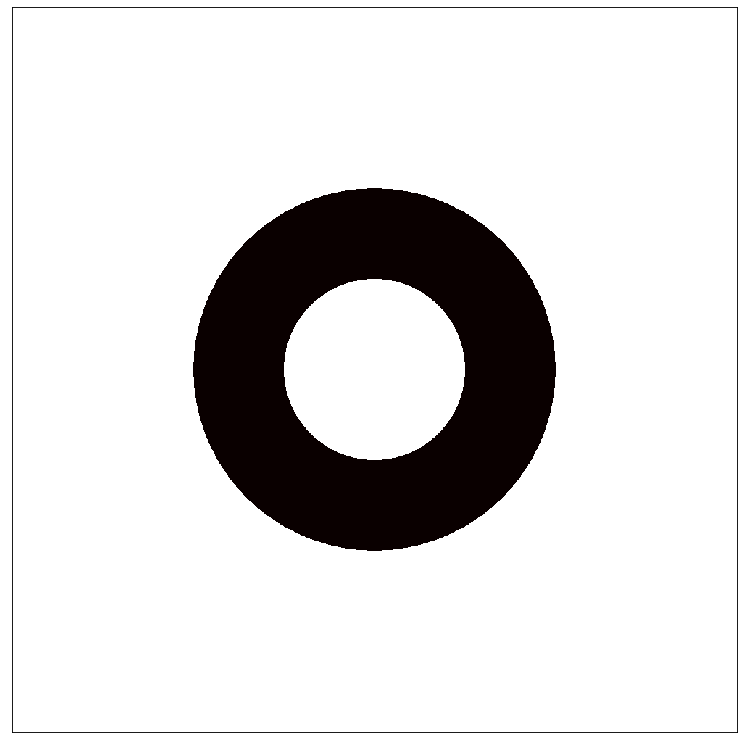

In [6]:
visualize(y_, vmin=0, vmax=1)

visualize range [5.412101745605469e-05, 1.0] mean 0.8530321717262268


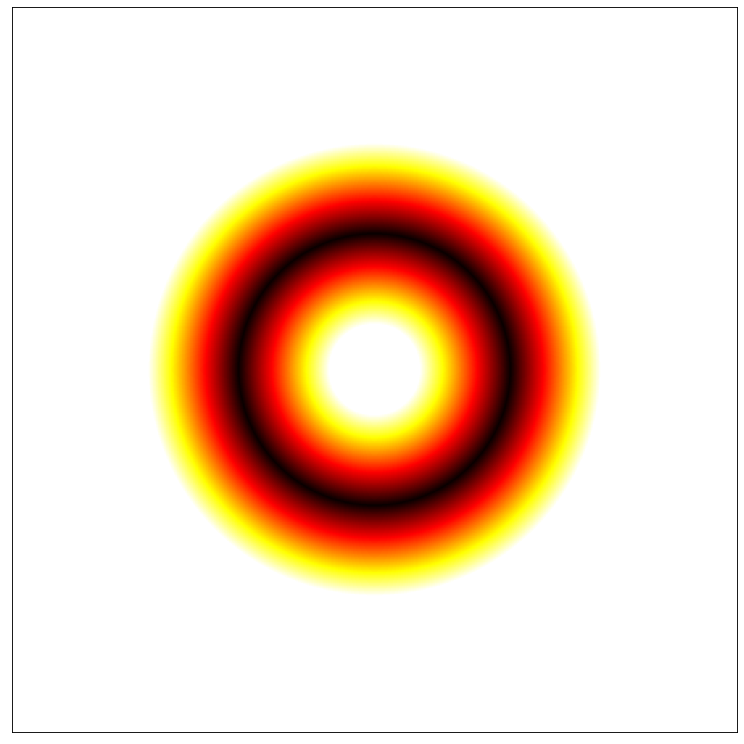

In [7]:
y_opt = (
    torch.lt(torch.norm(x_, p=2, dim=2), 0.5).float() * 1 + 
    torch.gt(torch.norm(x_, p=2, dim=2), 0.5).float() *
    torch.lt(torch.norm(x_, p=2, dim=2), 1.5).float() * 
        (1.5 - torch.norm(x_, p=2, dim=2)) + 
    torch.gt(torch.norm(x_, p=2, dim=2), 1.5).float() *
    torch.lt(torch.norm(x_, p=2, dim=2), 2.5).float() * 
        (-1.5 + torch.norm(x_, p=2, dim=2)) + 
    torch.gt(torch.norm(x_, p=2, dim=2), 2.5).float() * 1
)

visualize(y_opt, vmin=0, vmax=1)

visualize range [0.0, 0.49997687339782715] mean 0.07348400354385376


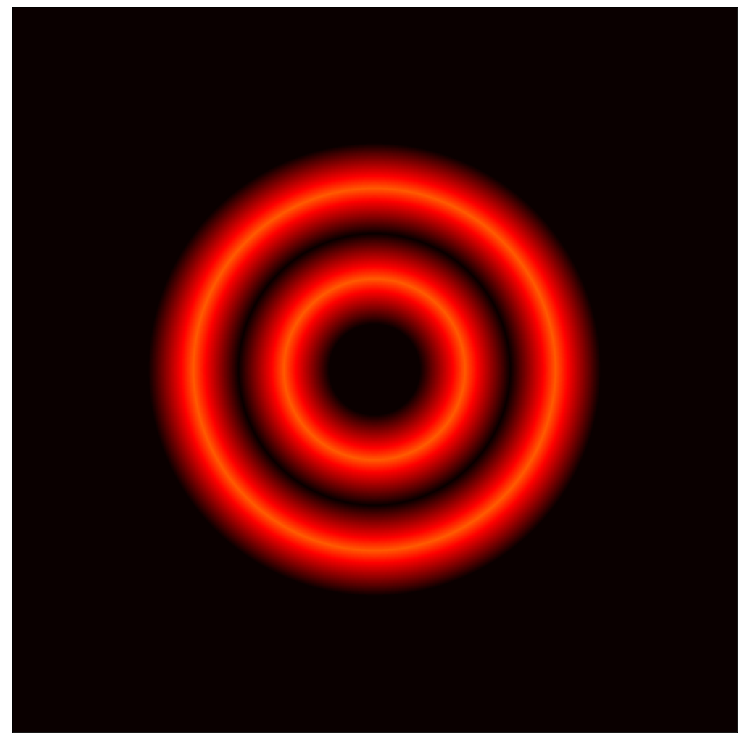

In [8]:
y_opt_error = torch.abs(y_ - y_opt)

visualize(y_opt_error, vmin=0, vmax=1)

visualize range [0.0, 1.0] mean 0.293971985578537


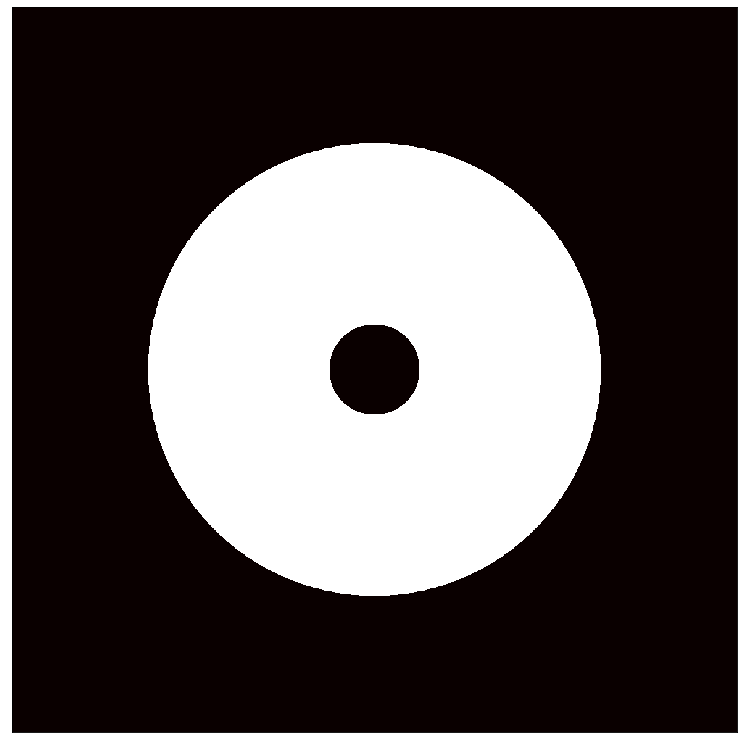

In [9]:
y_opt_gradient = (
    torch.lt(torch.norm(x_, p=2, dim=2), 0.5).float() * 0 + 
    torch.gt(torch.norm(x_, p=2, dim=2), 0.5).float() *
    torch.lt(torch.norm(x_, p=2, dim=2), 2.5).float() * 1 + 
    torch.gt(torch.norm(x_, p=2, dim=2), 2.5).float() * 0
)

visualize(y_opt_gradient, vmin=0, vmax=1)

In [10]:
def visualize_gradient_error(f):
    visualize(
        torch.abs(
            gradient_norm(f=f, x=x_.view(dim**2, 2).cuda()).detach().cpu().view(dim, dim) - 
            y_opt_gradient
        ).flip(0),
        vmin=0, vmax=1
    )

In [10]:
# base
f_base = nn.Sequential(
    nn.Linear(2, 20),
    nn.ReLU(),
    nn.Linear(20, 40),
    nn.ReLU(),
    nn.Linear(40, 20),
    nn.ReLU(),
    nn.Linear(20, 1)
).cuda()

optimizer = torch.optim.Adam(f_base.parameters())

t = tqdm(iter(dataloader))
for step, batch in enumerate(t):
    x, y, x_reg = upload(batch[0]), upload(batch[1]), upload(batch[2]).view(-1, 2)
    optimizer.zero_grad()
    y_hat = f_base(x)
    loss = F.mse_loss(y_hat, y)
    loss.backward()
    optimizer.step()
    t.set_description(f"loss={loss.item()}")


visualize range [0.0002641736064106226, 12.055232048034668] mean 0.5025141835212708


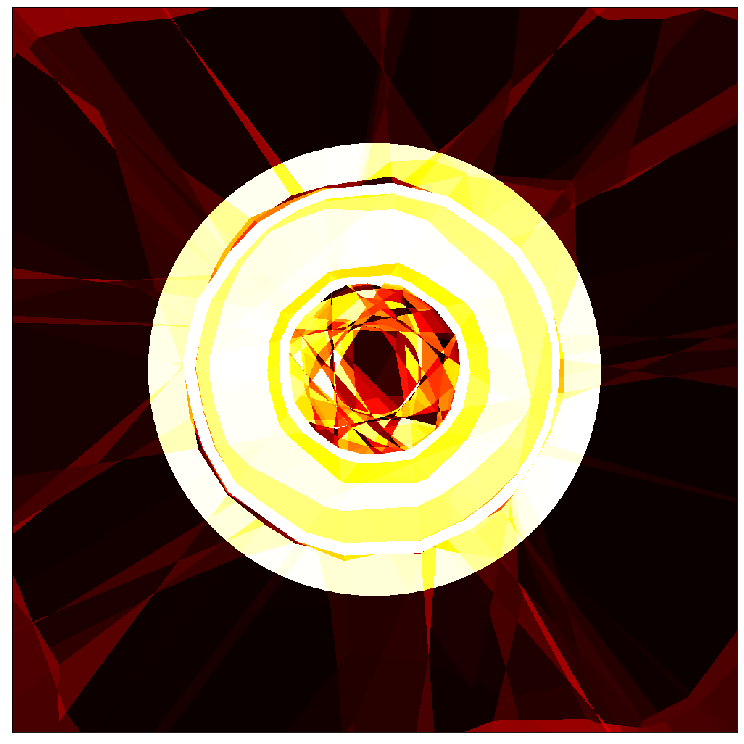

In [11]:
visualize_gradient_error(f_base)

visualize range [-0.01897445321083069, 1.1592293977737427] mean 0.8521371483802795


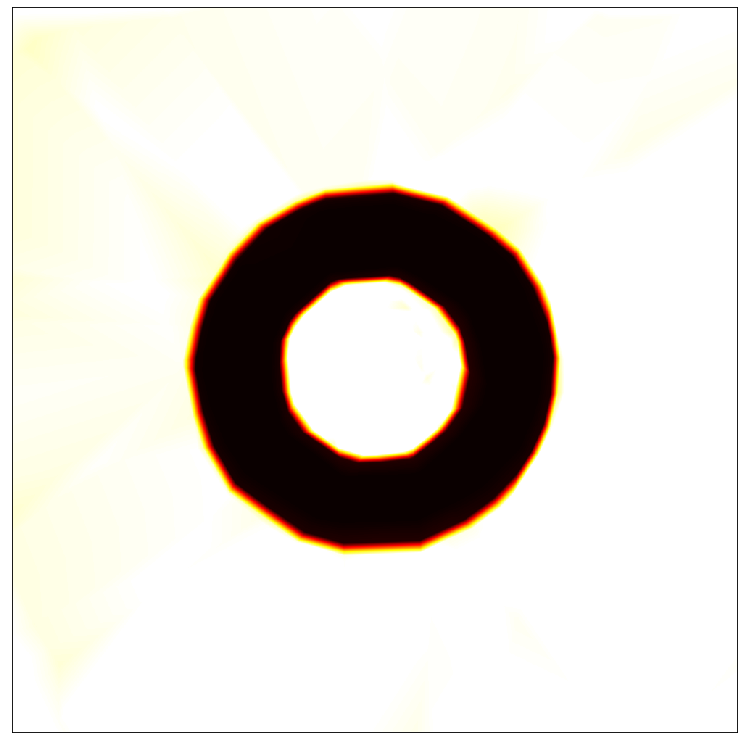

In [12]:
visualize_map(f_base)

visualize range [0.0, 0.9302265048027039] mean 0.022445909678936005


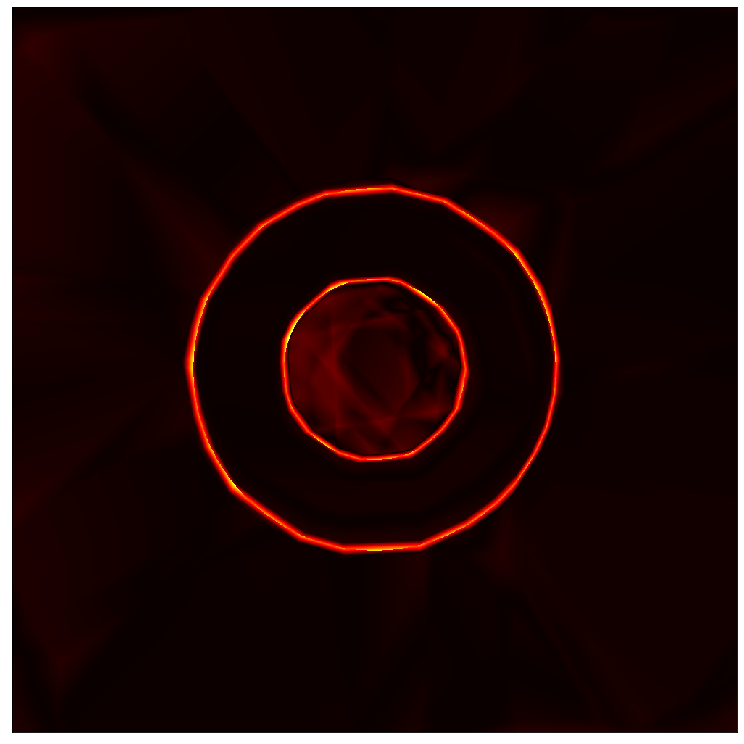

In [13]:
visualize_error(f_base)

visualize range [0.0002641736064106226, 13.055232048034668] mean 0.3491160571575165


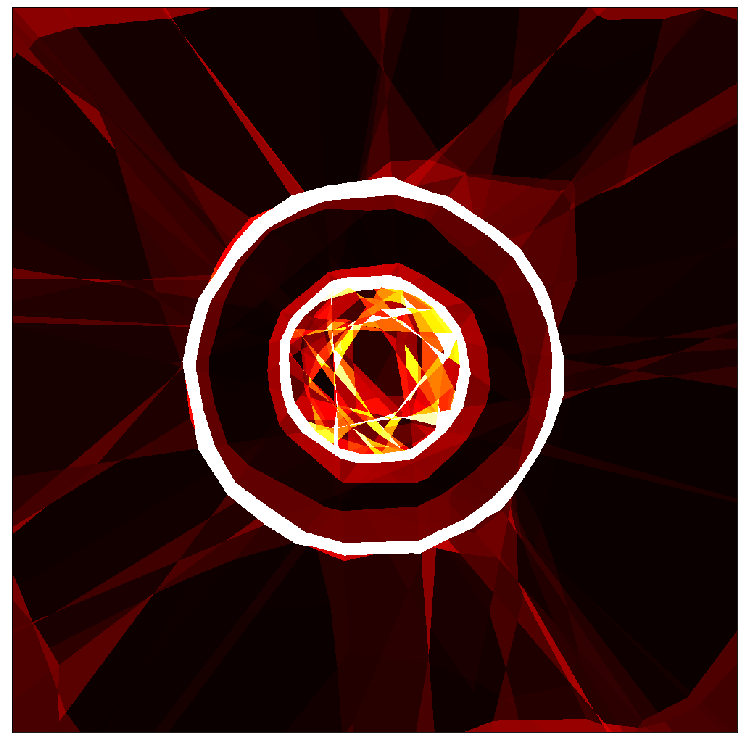

In [14]:
visualize_gradients(f_base)

In [15]:
# SN
f_sn = nn.Sequential(
    torch.nn.utils.spectral_norm(nn.Linear(2, 20)),
    nn.ReLU(),
    torch.nn.utils.spectral_norm(nn.Linear(20, 40)),
    nn.ReLU(),
    torch.nn.utils.spectral_norm(nn.Linear(40, 20)),
    nn.ReLU(),
    torch.nn.utils.spectral_norm(nn.Linear(20, 1))
).cuda()

optimizer = torch.optim.Adam(f_sn.parameters())

t = tqdm(iter(dataloader))
for step, batch in enumerate(t):
    x, y, x_reg = upload(batch[0]), upload(batch[1]), upload(batch[2]).view(-1, 2)
    optimizer.zero_grad()
    y_hat = f_sn(x)
    loss = F.mse_loss(y_hat, y)
    loss.backward()
    optimizer.step()
    t.set_description(f"loss={loss.item()}")


visualize range [0.0022718645632267, 0.993259072303772] mean 0.24929626286029816


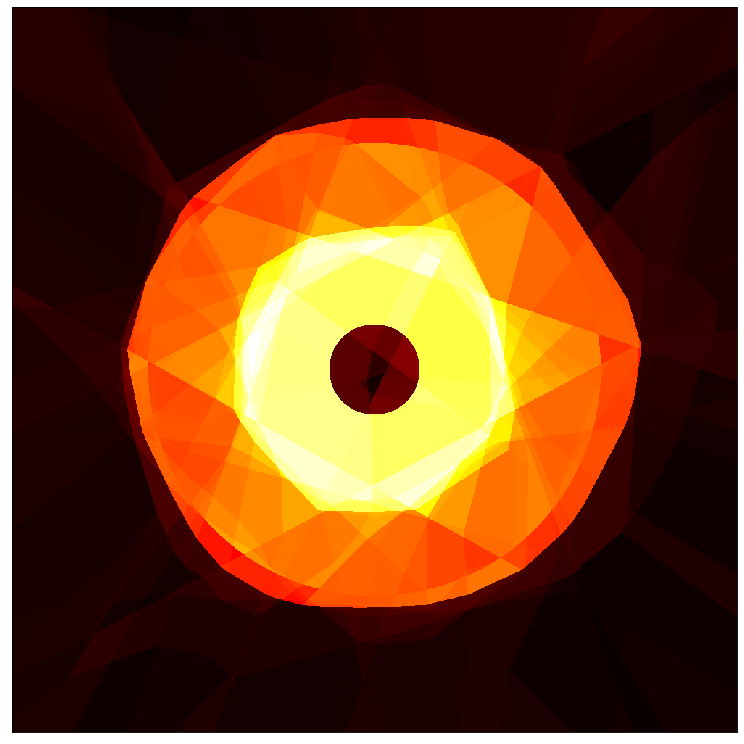

In [16]:
visualize_gradient_error(f_sn)

visualize range [0.34898608922958374, 1.0409035682678223] mean 0.8584766387939453


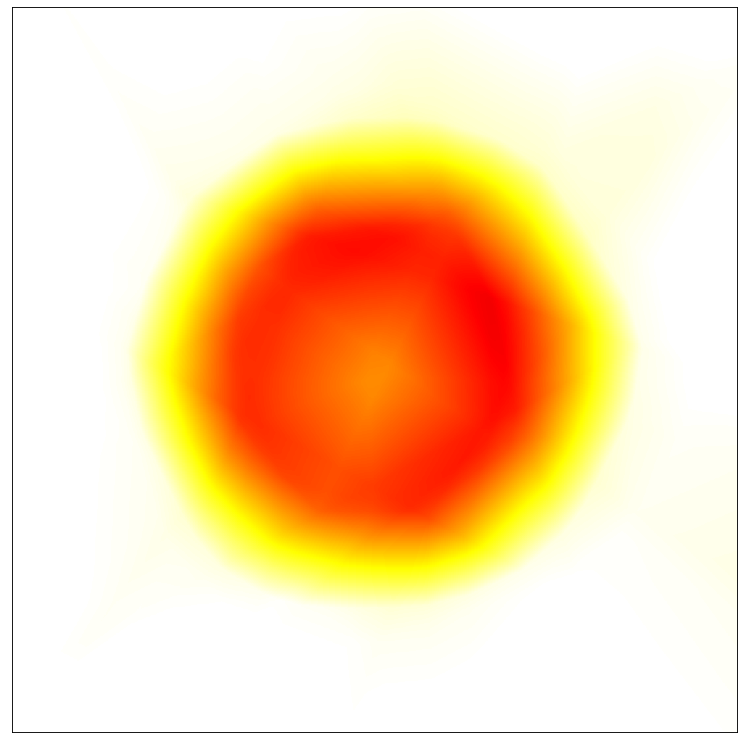

In [17]:
visualize_map(f_sn)

visualize range [0.0, 0.6657169461250305] mean 0.13907591998577118


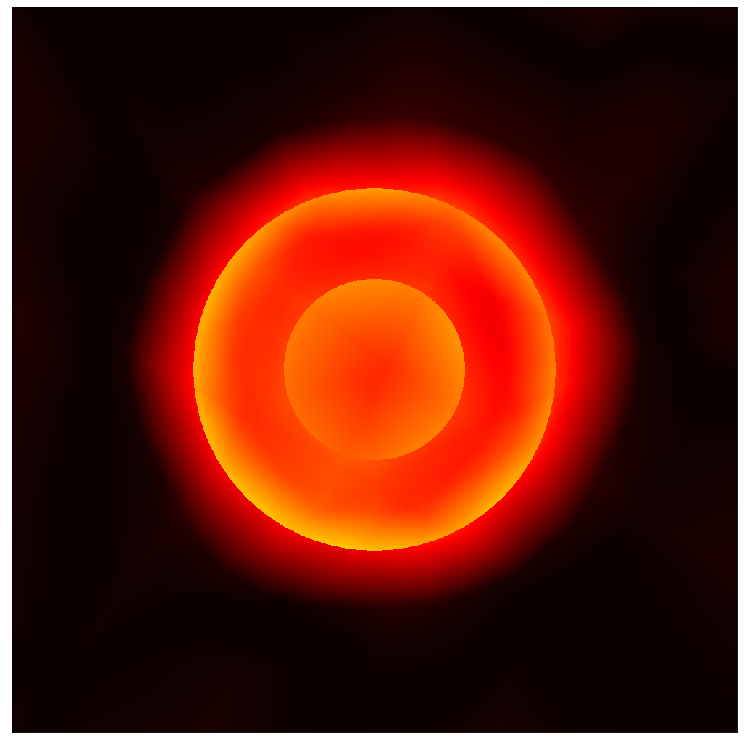

In [18]:
visualize_error(f_sn)

visualize range [0.002254214370623231, 0.5594414472579956] mean 0.15140195190906525


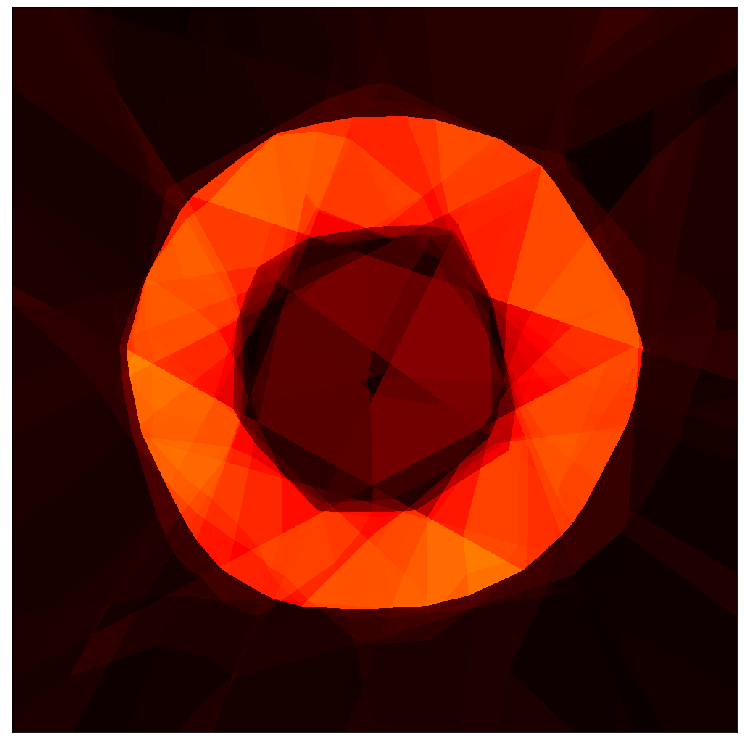

In [19]:
visualize_gradients(f_sn)

In [20]:
# LP \lambda 0.1
f_lp_l01 = nn.Sequential(
    nn.Linear(2, 20),
    nn.ReLU(),
    nn.Linear(20, 40),
    nn.ReLU(),
    nn.Linear(40, 20),
    nn.ReLU(),
    nn.Linear(20, 1)
).cuda()

optimizer = torch.optim.Adam(f_lp_l01.parameters())

lambda_lp = 0.1

t = tqdm(iter(dataloader))
for step, batch in enumerate(t):
    x, y, x_reg = upload(batch[0]), upload(batch[1]), upload(batch[2]).view(-1, 2)
    optimizer.zero_grad()
    
    gradient_penalty = lambda_lp * (torch.clamp(gradient_norm(f=f_lp_l01, x=x_reg) - 1, min=0) ** 2).mean()
    
    y_hat = f_lp_l01(x)
    loss = F.mse_loss(y_hat, y)
    (loss + gradient_penalty).backward()
    optimizer.step()
    t.set_description(f"loss={loss.item()}")
    

visualize range [3.361701965332031e-05, 1.1052830219268799] mean 0.14120744168758392


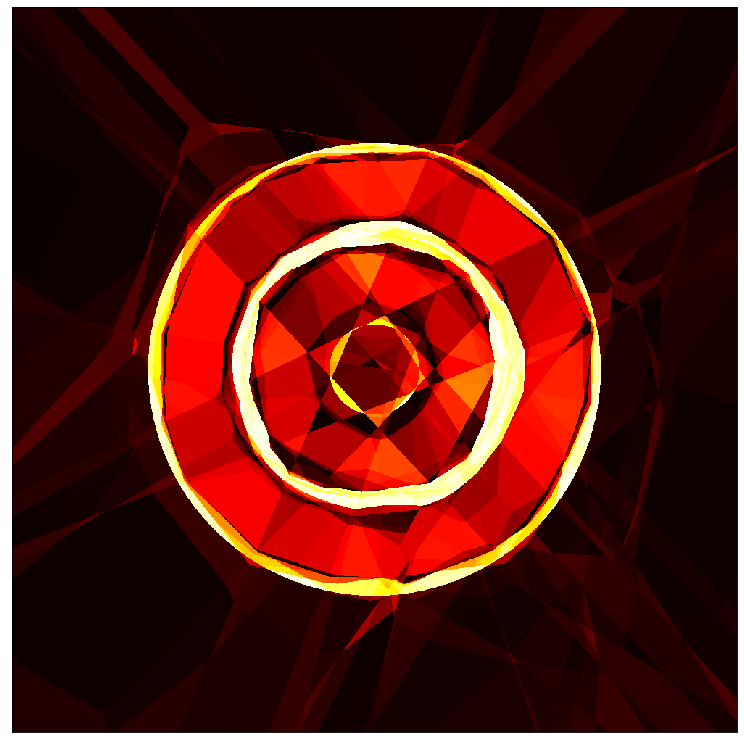

In [21]:
visualize_gradient_error(f_lp_l01)

visualize range [-0.03969508409500122, 1.1142206192016602] mean 0.8486455678939819


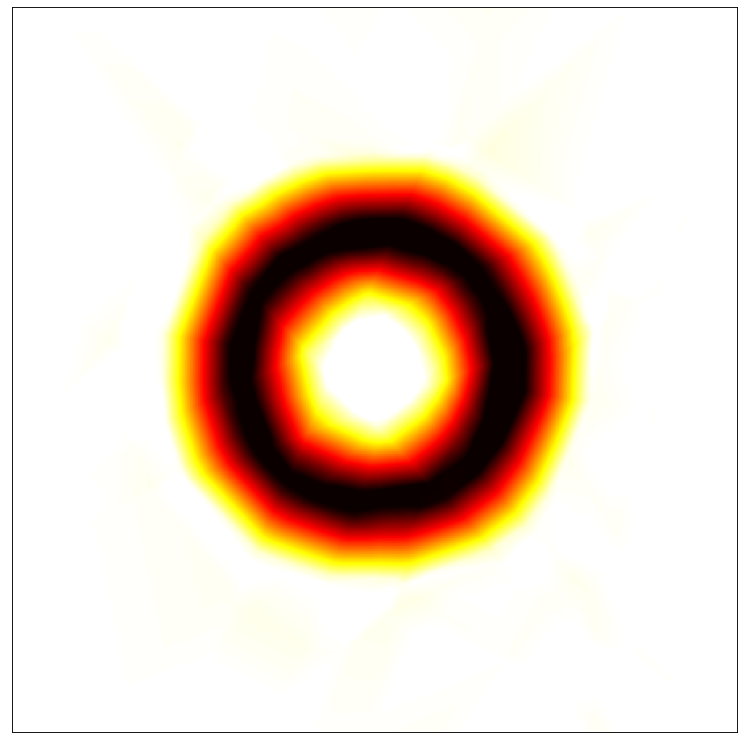

In [22]:
visualize_map(f_lp_l01)

visualize range [0.0, 0.5968499183654785] mean 0.06254014372825623


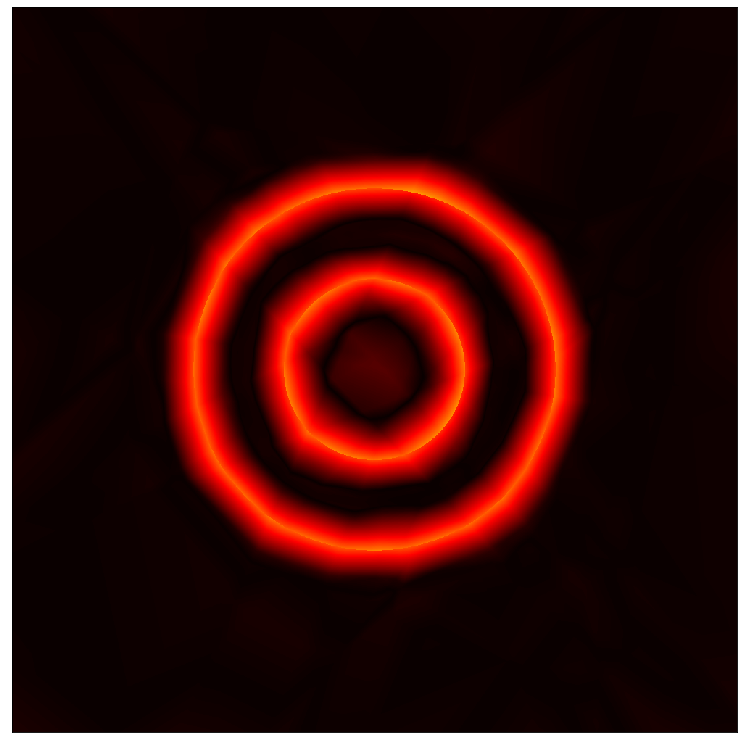

In [23]:
visualize_error(f_lp_l01)

visualize range [0.001364892115816474, 1.5608205795288086] mean 0.32513725757598877


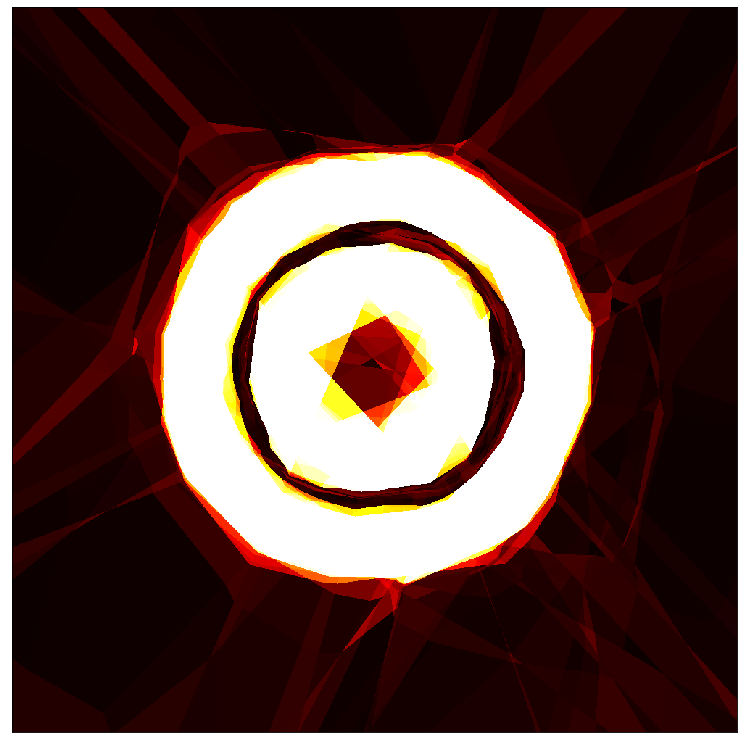

In [24]:
visualize_gradients(f_lp_l01)

In [25]:
# LP \lambda 1
f_lp_l1 = nn.Sequential(
    nn.Linear(2, 20),
    nn.ReLU(),
    nn.Linear(20, 40),
    nn.ReLU(),
    nn.Linear(40, 20),
    nn.ReLU(),
    nn.Linear(20, 1)
).cuda()

optimizer = torch.optim.Adam(f_lp_l1.parameters())

lambda_lp = 1

t = tqdm(iter(dataloader))
for step, batch in enumerate(t):
    x, y, x_reg = upload(batch[0]), upload(batch[1]), upload(batch[2]).view(-1, 2)
    optimizer.zero_grad()
    
    gradient_penalty = lambda_lp * (torch.clamp(gradient_norm(f=f_lp_l1, x=x_reg) - 1, min=0) ** 2).mean()
    
    y_hat = f_lp_l1(x)
    loss = F.mse_loss(y_hat, y)
    (loss + gradient_penalty).backward()
    optimizer.step()
    t.set_description(f"loss={loss.item()}")
    

visualize range [9.644031524658203e-05, 1.0346736907958984] mean 0.05113162472844124


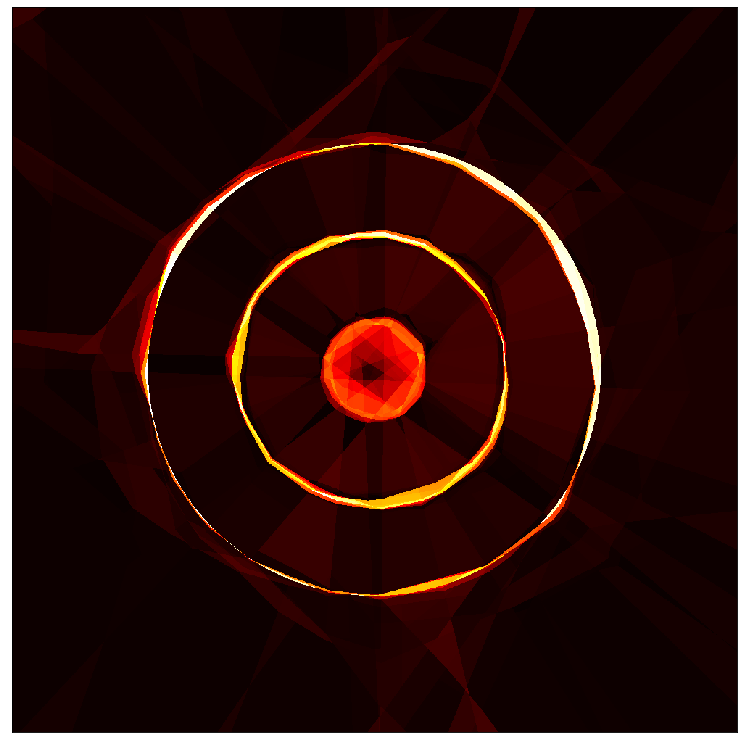

In [26]:
visualize_gradient_error(f_lp_l1)

visualize range [-0.007353112101554871, 1.1117950677871704] mean 0.8490879535675049


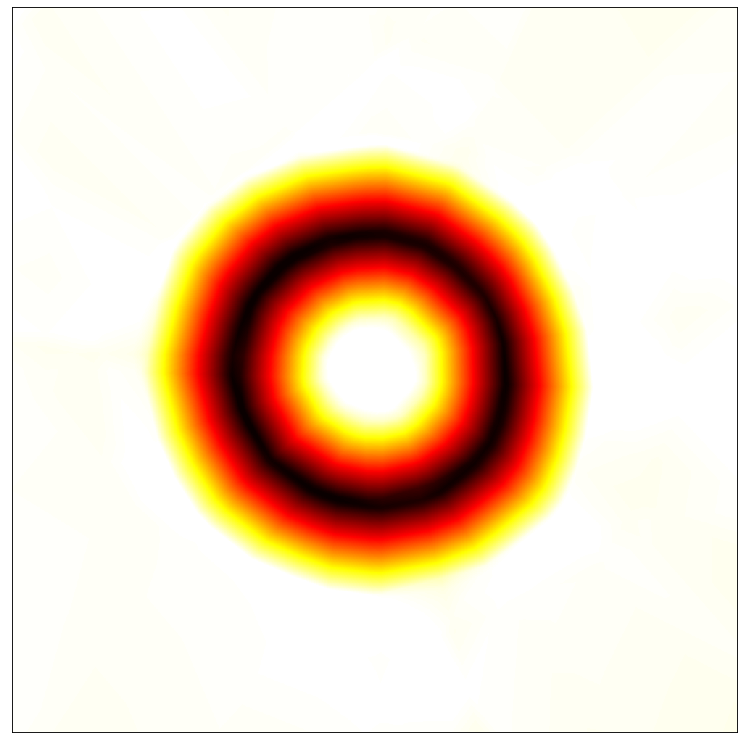

In [27]:
visualize_map(f_lp_l1)

visualize range [5.960464477539063e-08, 0.6014264225959778] mean 0.07709339261054993


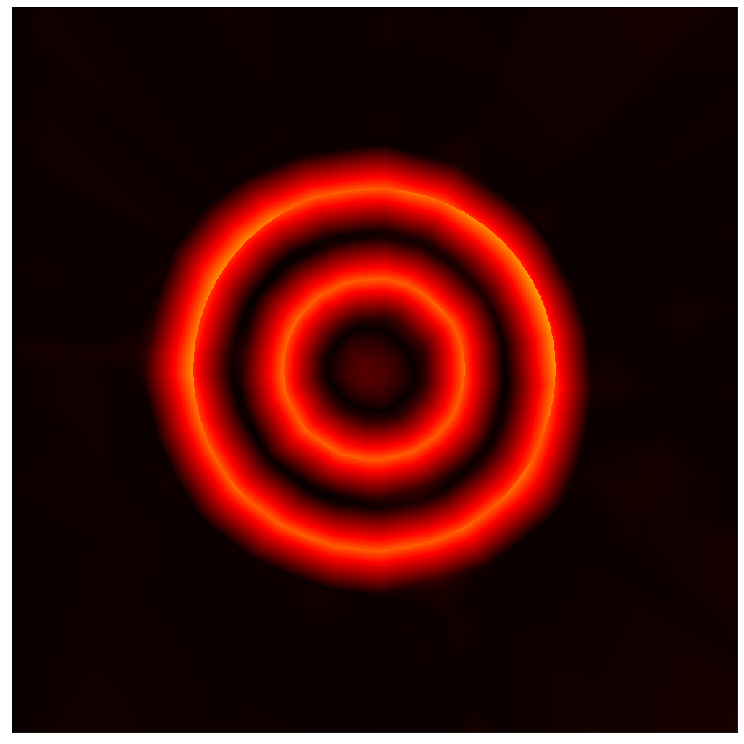

In [28]:
visualize_error(f_lp_l1)

visualize range [0.0014808132546022534, 1.103009581565857] mean 0.30809199810028076


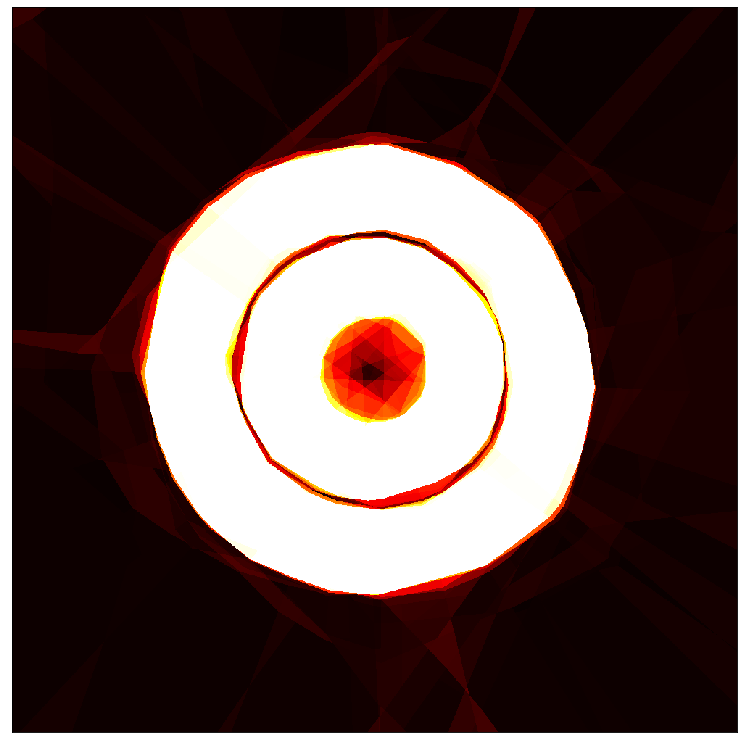

In [29]:
visualize_gradients(f_lp_l1)

In [30]:
# LP \lambda 10
f_lp_l10 = nn.Sequential(
    nn.Linear(2, 20),
    nn.ReLU(),
    nn.Linear(20, 40),
    nn.ReLU(),
    nn.Linear(40, 20),
    nn.ReLU(),
    nn.Linear(20, 1)
).cuda()

optimizer = torch.optim.Adam(f_lp_l10.parameters())

lambda_lp = 10

t = tqdm(iter(dataloader))
for step, batch in enumerate(t):
    x, y, x_reg = upload(batch[0]), upload(batch[1]), upload(batch[2]).view(-1, 2)
    optimizer.zero_grad()
    
    gradient_penalty = lambda_lp * (torch.clamp(gradient_norm(f=f_lp_l10, x=x_reg) - 1, min=0) ** 2).mean()
    
    y_hat = f_lp_l10(x)
    loss = F.mse_loss(y_hat, y)
    (loss + gradient_penalty).backward()
    optimizer.step()
    t.set_description(f"loss={loss.item()}")
    

visualize range [2.6226043701171875e-05, 1.0153748989105225] mean 0.040623120963573456


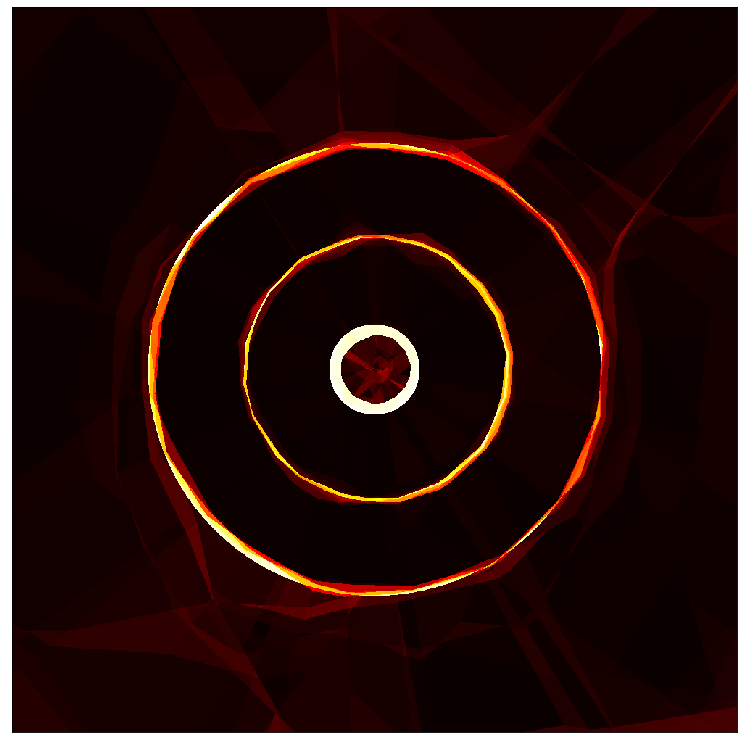

In [31]:
visualize_gradient_error(f_lp_l10)

visualize range [-0.003994792699813843, 1.072214126586914] mean 0.8499287366867065


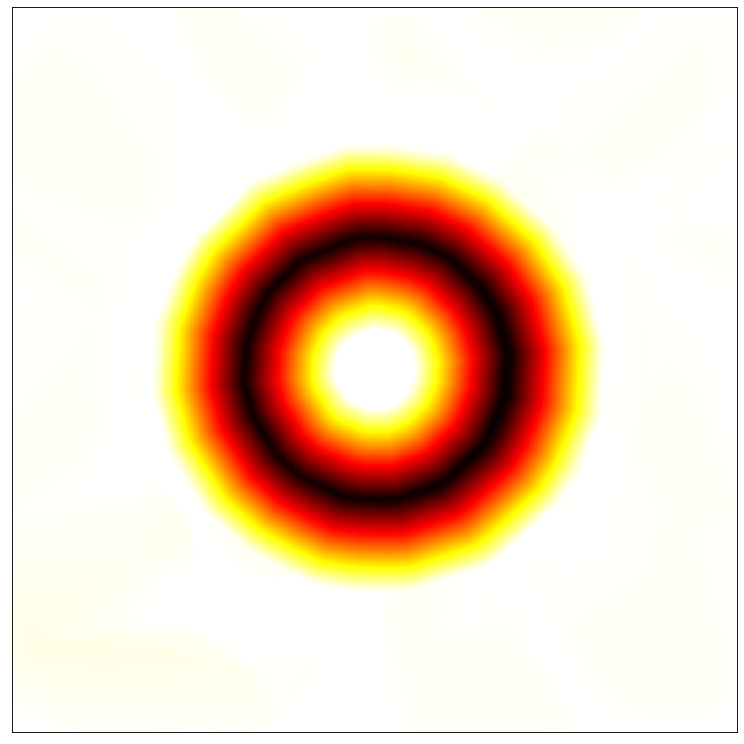

In [32]:
visualize_map(f_lp_l10)

visualize range [0.0, 0.5877403020858765] mean 0.07825542241334915


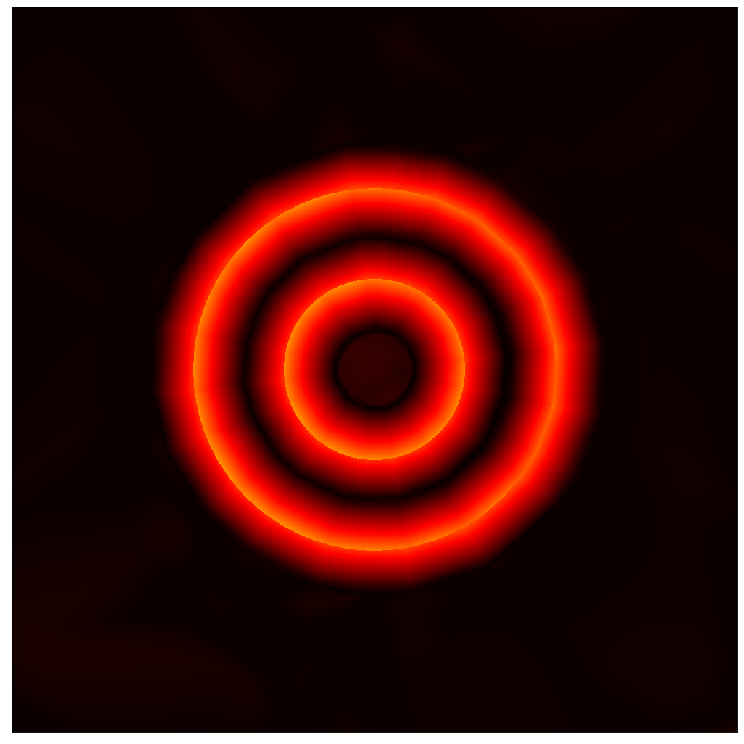

In [33]:
visualize_error(f_lp_l10)

visualize range [0.0011683970224112272, 1.0168057680130005] mean 0.3005940616130829


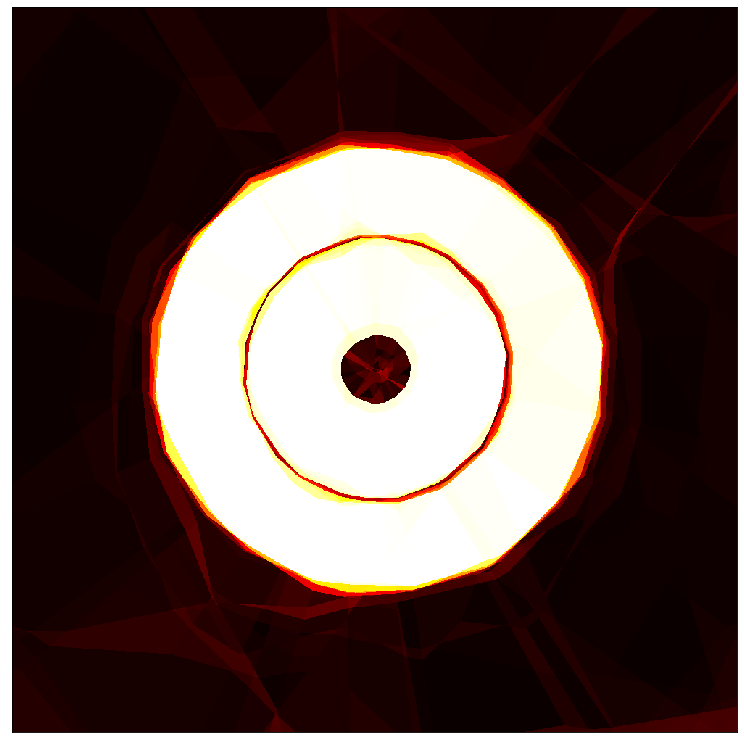

In [34]:
visualize_gradients(f_lp_l10)

In [65]:
class ALR(object):
    def __init__(self, d_X, d_Y, eps_min, eps_max, xi, ip, K):
        super(ALR, self).__init__()
        self.d_X = d_X
        self.d_Y = d_Y
        self.eps_min = eps_min
        self.eps_max = eps_max
        if eps_min == eps_max:
            self.eps = lambda x: eps_min * torch.ones(x.size(0), 1, device=x.device)
        else:
            self.eps = lambda x: torch.distributions.uniform.Uniform(
                low=eps_min, high=eps_max
            ).sample(
                sample_shape=(x.size(0), 1)
            ).cuda()
        self.xi = xi
        self.ip = ip
        self.K = K
    
    def adversarial_direction(self, f, x):
        batch_size = x.size(0)
        y = f(x).detach()
        f.zero_grad()
        normalize = lambda vector: F.normalize(vector, p=2, dim=1)
        d = torch.rand_like(x) - 0.5
        for _ in range(self.ip):
            d = normalize(d)
            d.requires_grad_()
            x_hat = x + self.xi * d
            y_hat = f(x_hat)
            y_diff = self.d_Y(y, y_hat)
            y_diff = torch.mean(y_diff)
            y_diff.backward()
            d = d.grad.detach()
            f.zero_grad()
        r_adv = normalize(d) * self.eps(x)
        # remove too small values
        r_adv_mask = torch.lt(torch.norm(r_adv, p=2, dim=1, keepdim=True), self.eps_min).float()
        r_adv = (1 - r_adv_mask) * r_adv + r_adv_mask * normalize(torch.rand_like(x) - 0.5)
        f.zero_grad()
        return r_adv
        
    def get_adversarial_perturbations(self, f, x):
        r_adv = self.adversarial_direction(f=f, x=x.detach())
        x_hat = x + r_adv
        return x_hat

    def get_alp(self, x, x_hat, y, y_hat):
        y_diff = self.d_Y(y, y_hat)
        x_diff = self.d_X(x, x_hat)
        lip_ratio = y_diff / x_diff
        alp = torch.clamp(lip_ratio - self.K, min=0)
        nonzeros = torch.nonzero(alp)
        alp_count = nonzeros.size(0)
        return (
            alp, lip_ratio, x_diff, y_diff, alp_count
        )

In [66]:
# ALP \lambda 01 ip 0
f_alp_l01_ip0 = nn.Sequential(
    nn.Linear(2, 20),
    nn.ReLU(),
    nn.Linear(20, 40),
    nn.ReLU(),
    nn.Linear(40, 20),
    nn.ReLU(),
    nn.Linear(20, 1)
).cuda()

optimizer = torch.optim.Adam(f_alp_l01_ip0.parameters())

alr = ALR(
    d_X=lambda x, x_hat: torch.norm(x - x_hat, p=2, dim=1, keepdim=True), 
    d_Y=lambda y, y_hat: torch.abs(y - y_hat), 
    eps_min=1e-6, 
    eps_max=1e-5,
    xi=1e-1, 
    ip=0, 
    K=1
)

lambda_alp = 0.1

t = tqdm(iter(dataloader))
for step, batch in enumerate(t):
    x, y, x_reg = upload(batch[0]), upload(batch[1]), upload(batch[2]).view(-1, 2)

    optimizer.zero_grad()
    
    x_hat = alr.get_adversarial_perturbations(
        f=f_alp_l01_ip0, x=x_reg
    )
    
    y_hat = f_alp_l01_ip0(x)
    loss = F.mse_loss(y_hat, y)
    
    alp, lip_ratio, x_diff, y_diff, alp_count = alr.get_alp(
        x=x_reg, x_hat=x_hat, y=f_alp_l01_ip0(x_reg), y_hat=f_alp_l01_ip0(x_hat)
    )
    
    alp_loss = lambda_alp * (alp ** 2).mean()
    
    (loss + alp_loss).backward()
    optimizer.step()
    t.set_description(f"loss={loss.item()} count={alp_count} lip={lip_ratio.max().item()}")
    

visualize range [0.00043654441833496094, 1.124908447265625] mean 0.223478764295578


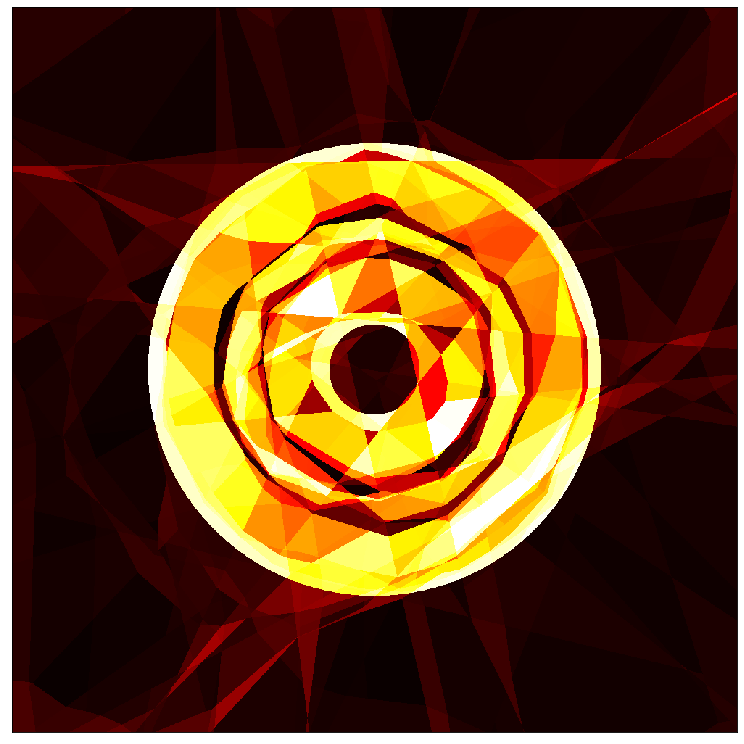

In [67]:
visualize_gradient_error(f_alp_l01_ip0)

visualize range [-0.1501469612121582, 1.0478553771972656] mean 0.8447327613830566


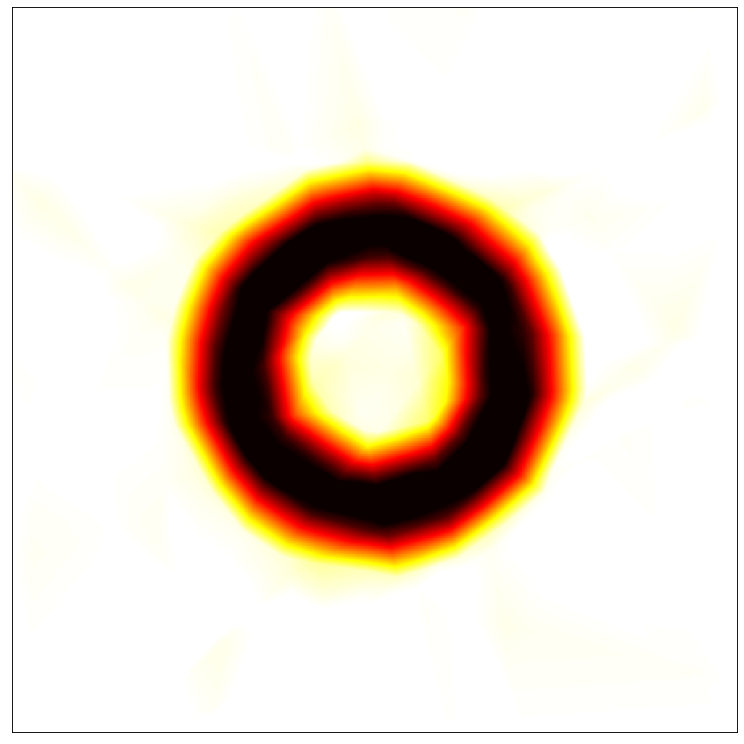

In [68]:
visualize_map(f_alp_l01_ip0)

visualize range [0.0, 0.6593887805938721] mean 0.05452132970094681


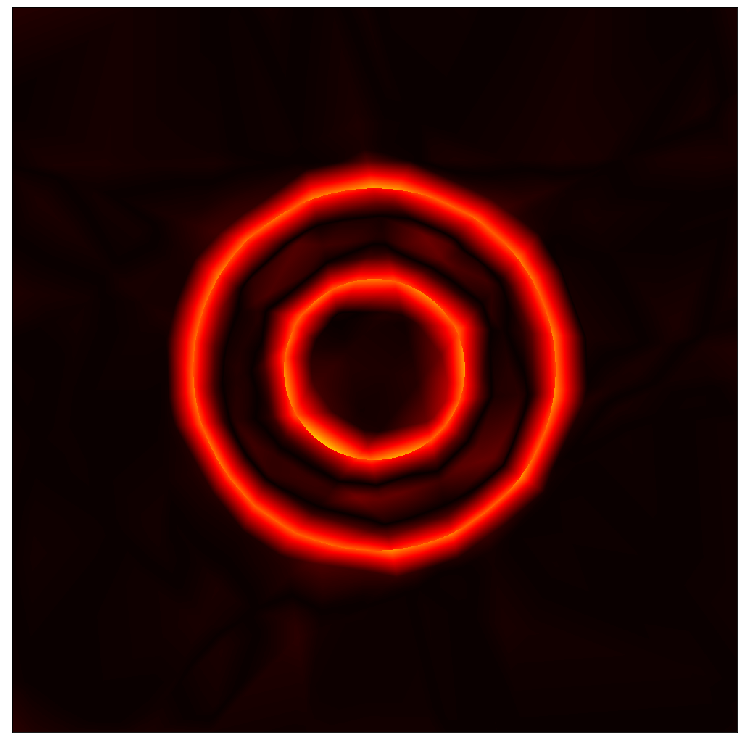

In [69]:
visualize_error(f_alp_l01_ip0)

visualize range [0.0018989647505804896, 2.124908447265625] mean 0.34460389614105225


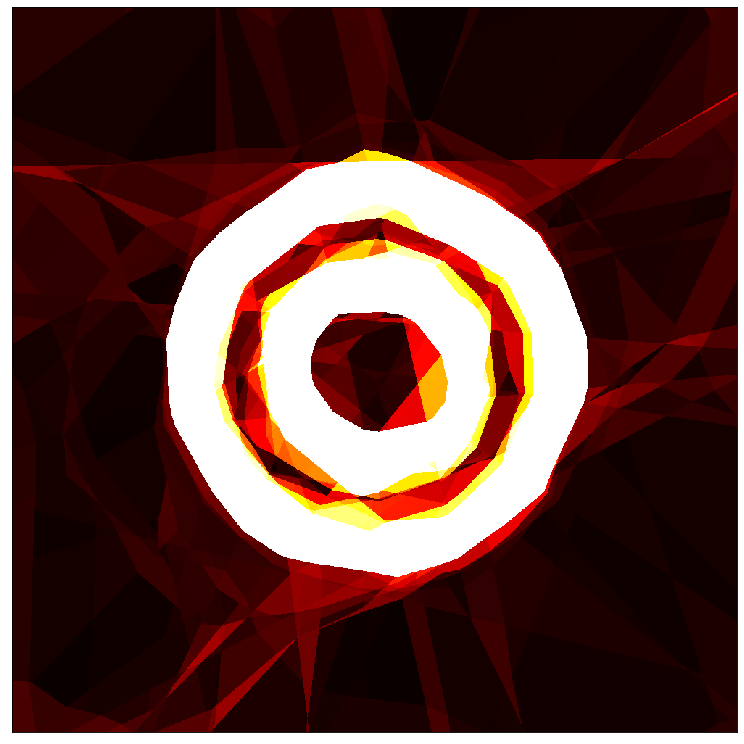

In [70]:
visualize_gradients(f_alp_l01_ip0)

In [71]:
# ALP \lambda 1 ip 0
f_alp_l1_ip0 = nn.Sequential(
    nn.Linear(2, 20),
    nn.ReLU(),
    nn.Linear(20, 40),
    nn.ReLU(),
    nn.Linear(40, 20),
    nn.ReLU(),
    nn.Linear(20, 1)
).cuda()

optimizer = torch.optim.Adam(f_alp_l1_ip0.parameters())

alr = ALR(
    d_X=lambda x, x_hat: torch.norm(x - x_hat, p=2, dim=1, keepdim=True), 
    d_Y=lambda y, y_hat: torch.abs(y - y_hat), 
    eps_min=1e-6, 
    eps_max=1e-5,
    xi=1e-1, 
    ip=0, 
    K=1
)

lambda_alp = 1

t = tqdm(iter(dataloader))
for step, batch in enumerate(t):
    x, y, x_reg = upload(batch[0]), upload(batch[1]), upload(batch[2]).view(-1, 2)

    optimizer.zero_grad()
    
    x_hat = alr.get_adversarial_perturbations(
        f=f_alp_l1_ip0, x=x_reg
    )
    
    y_hat = f_alp_l1_ip0(x)
    loss = F.mse_loss(y_hat, y)
    
    alp, lip_ratio, x_diff, y_diff, alp_count = alr.get_alp(
        x=x_reg, x_hat=x_hat, y=f_alp_l1_ip0(x_reg), y_hat=f_alp_l1_ip0(x_hat)
    )
    
    alp_loss = lambda_alp * (alp ** 2).mean()
    
    (loss + alp_loss).backward()
    optimizer.step()
    t.set_description(f"loss={loss.item()} count={alp_count} lip={lip_ratio.max().item()}")
    

visualize range [0.00013184547424316406, 0.9927746057510376] mean 0.10879514366388321


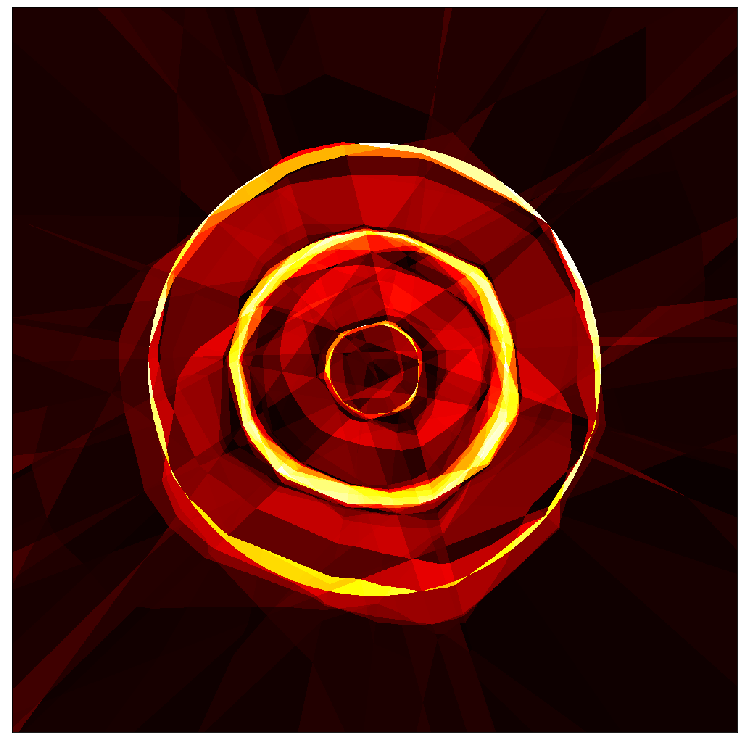

In [72]:
visualize_gradient_error(f_alp_l1_ip0)

visualize range [-0.06564054638147354, 1.0447638034820557] mean 0.852766752243042


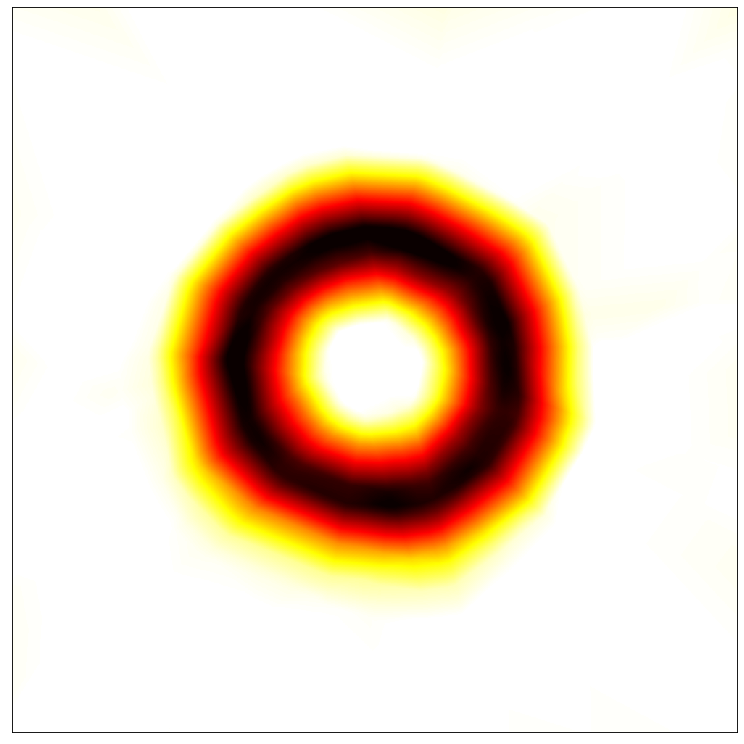

In [73]:
visualize_map(f_alp_l1_ip0)

visualize range [0.0, 0.6359622478485107] mean 0.07048635929822922


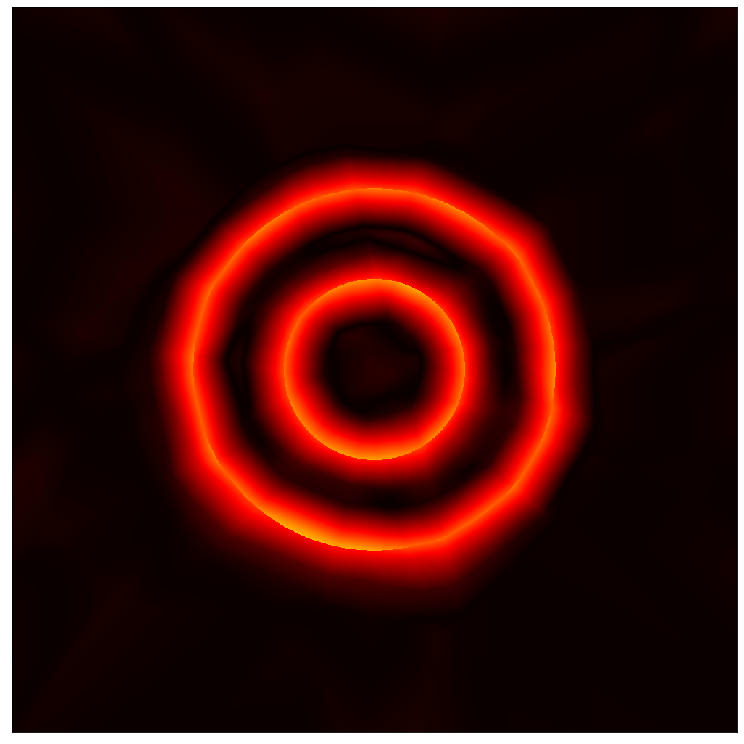

In [74]:
visualize_error(f_alp_l1_ip0)

visualize range [0.0016085192328318954, 1.4183577299118042] mean 0.3098762631416321


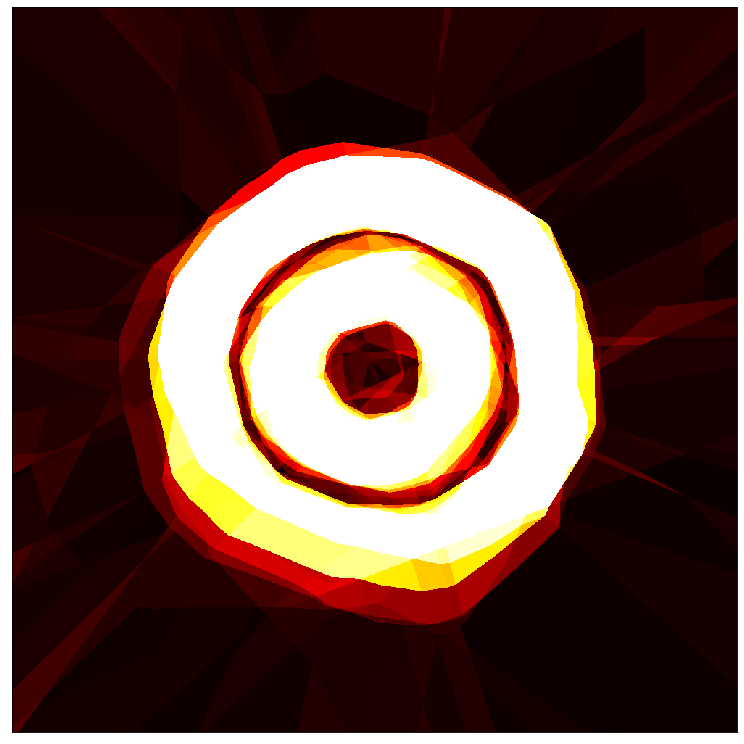

In [75]:
visualize_gradients(f_alp_l1_ip0)

In [76]:
# ALP \lambda 10 ip 0
f_alp_l10_ip0 = nn.Sequential(
    nn.Linear(2, 20),
    nn.ReLU(),
    nn.Linear(20, 40),
    nn.ReLU(),
    nn.Linear(40, 20),
    nn.ReLU(),
    nn.Linear(20, 1)
).cuda()

optimizer = torch.optim.Adam(f_alp_l10_ip0.parameters())

alr = ALR(
    d_X=lambda x, x_hat: torch.norm(x - x_hat, p=2, dim=1, keepdim=True), 
    d_Y=lambda y, y_hat: torch.abs(y - y_hat), 
    eps_min=1e-6, 
    eps_max=1e-5,
    xi=1e-1, 
    ip=0, 
    K=1
)

lambda_alp = 10

t = tqdm(iter(dataloader))
for step, batch in enumerate(t):
    x, y, x_reg = upload(batch[0]), upload(batch[1]), upload(batch[2]).view(-1, 2)

    optimizer.zero_grad()
    
    x_hat = alr.get_adversarial_perturbations(
        f=f_alp_l10_ip0, x=x_reg
    )
    
    y_hat = f_alp_l10_ip0(x)
    loss = F.mse_loss(y_hat, y)
    
    alp, lip_ratio, x_diff, y_diff, alp_count = alr.get_alp(
        x=x_reg, x_hat=x_hat, y=f_alp_l10_ip0(x_reg), y_hat=f_alp_l10_ip0(x_hat)
    )
    
    alp_loss = lambda_alp * (alp ** 2).mean()
    
    (loss + alp_loss).backward()
    optimizer.step()
    t.set_description(f"loss={loss.item()} count={alp_count} lip={lip_ratio.max().item()}")
    

visualize range [1.1861324310302734e-05, 1.0686612129211426] mean 0.056831344962120056


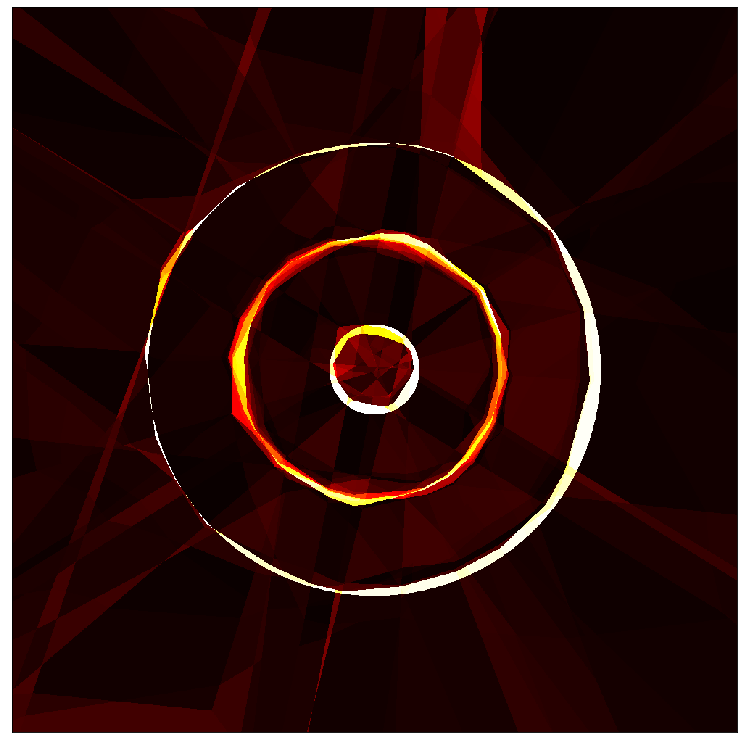

In [77]:
visualize_gradient_error(f_alp_l10_ip0)

visualize range [-0.029049821197986603, 1.0613398551940918] mean 0.8621373176574707


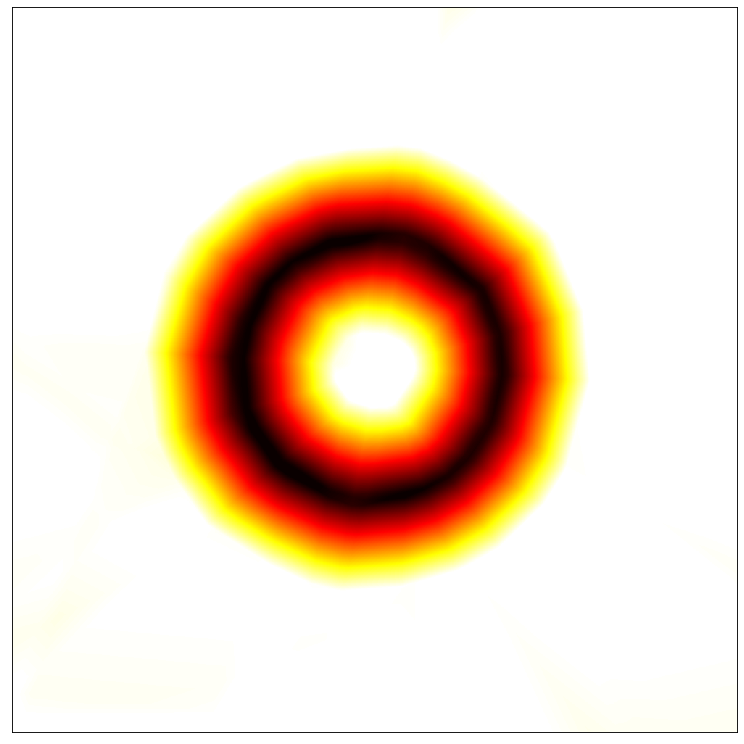

In [78]:
visualize_map(f_alp_l10_ip0)

visualize range [1.1920928955078125e-07, 0.649494469165802] mean 0.08149076253175735


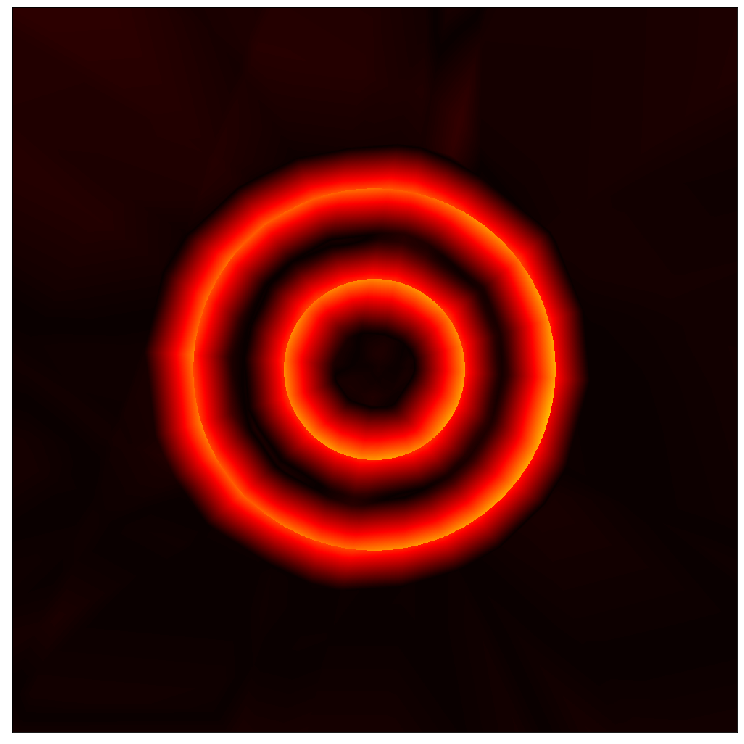

In [79]:
visualize_error(f_alp_l10_ip0)

visualize range [0.002215682528913021, 1.0857890844345093] mean 0.30305227637290955


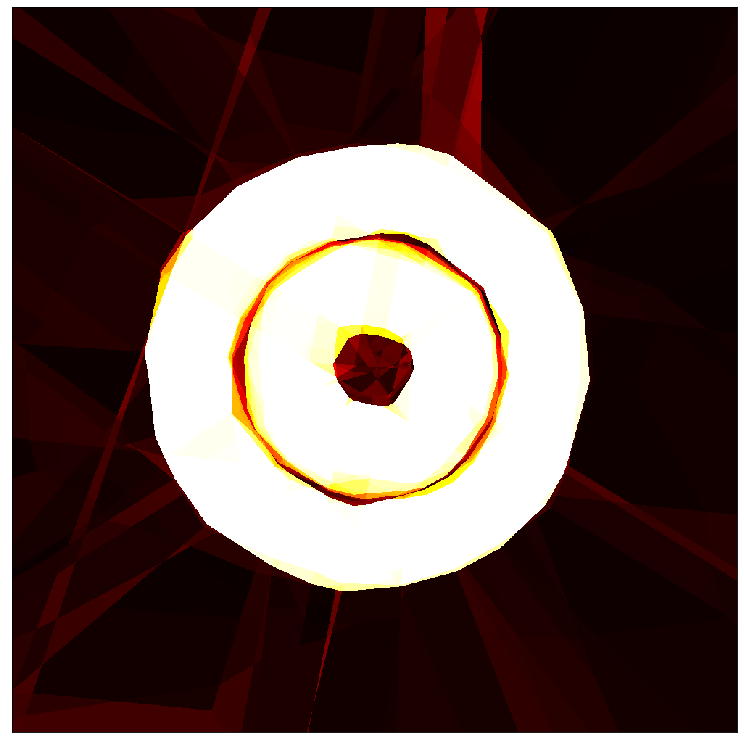

In [80]:
visualize_gradients(f_alp_l10_ip0)

In [81]:
# ALP \lambda 1 ip 1
f_alp_l01_ip1 = nn.Sequential(
    nn.Linear(2, 20),
    nn.ReLU(),
    nn.Linear(20, 40),
    nn.ReLU(),
    nn.Linear(40, 20),
    nn.ReLU(),
    nn.Linear(20, 1)
).cuda()

optimizer = torch.optim.Adam(f_alp_l01_ip1.parameters())

alr = ALR(
    d_X=lambda x, x_hat: torch.norm(x - x_hat, p=2, dim=1, keepdim=True), 
    d_Y=lambda y, y_hat: torch.abs(y - y_hat), 
    eps_min=1e-6, 
    eps_max=1e-5,
    xi=1e-1, 
    ip=1, 
    K=1
)

lambda_alp = 0.1

t = tqdm(iter(dataloader))
for step, batch in enumerate(t):
    x, y, x_reg = upload(batch[0]), upload(batch[1]), upload(batch[2]).view(-1, 2)

    optimizer.zero_grad()
    
    x_hat = alr.get_adversarial_perturbations(
        f=f_alp_l01_ip1, x=x_reg
    )
    
    y_hat = f_alp_l01_ip1(x)
    loss = F.mse_loss(y_hat, y)
    
    alp, lip_ratio, x_diff, y_diff, alp_count = alr.get_alp(
        x=x_reg, x_hat=x_hat, y=f_alp_l01_ip1(x_reg), y_hat=f_alp_l01_ip1(x_hat)
    )
    
    alp_loss = lambda_alp * (alp ** 2).mean()
    
    (loss + alp_loss).backward()
    optimizer.step()
    t.set_description(f"loss={loss.item()} count={alp_count} lip={lip_ratio.max().item()}")
    

visualize range [0.00011688470840454102, 1.1414037942886353] mean 0.13408957421779633


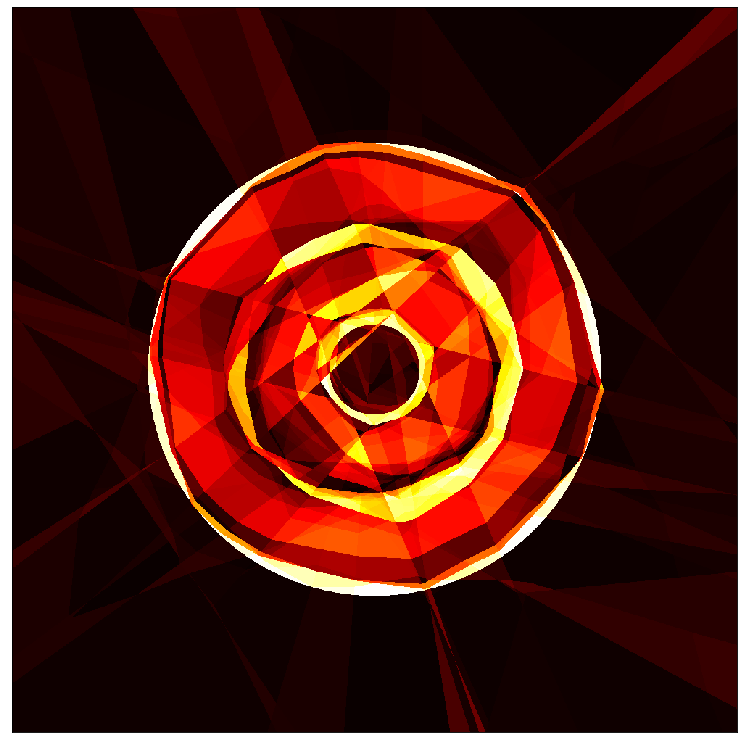

In [82]:
visualize_gradient_error(f_alp_l01_ip1)

visualize range [-0.10437940061092377, 1.0605911016464233] mean 0.8533121943473816


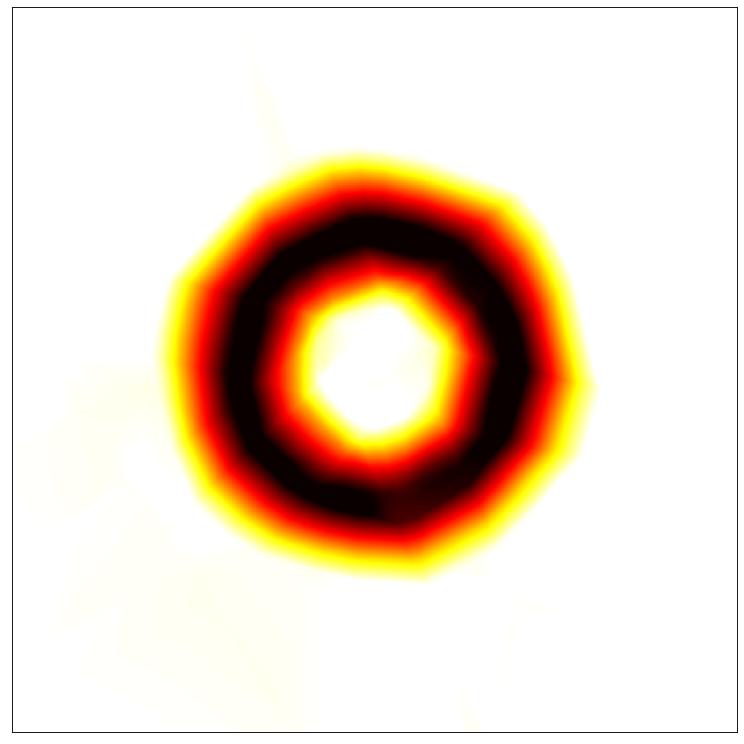

In [83]:
visualize_map(f_alp_l01_ip1)

visualize range [0.0, 0.6191664934158325] mean 0.06646266579627991


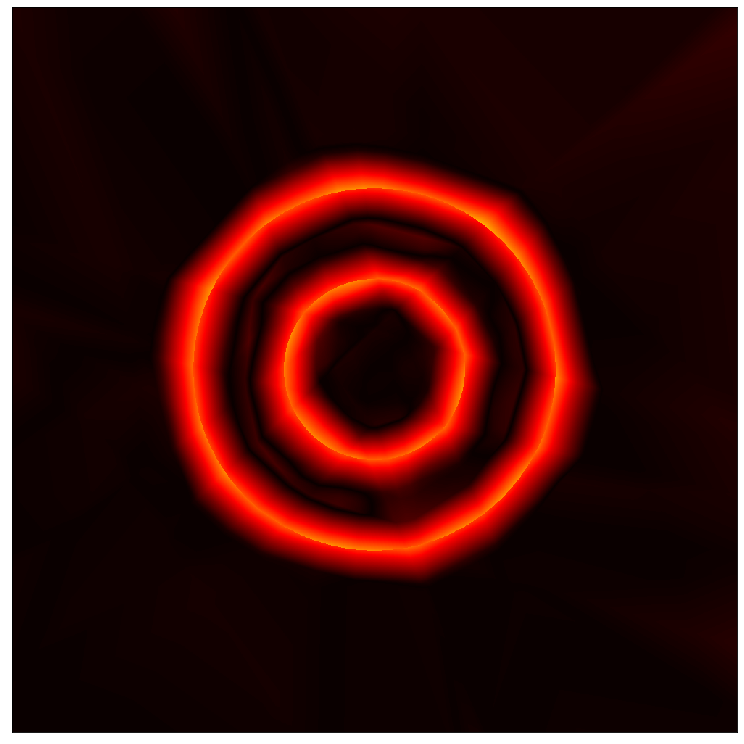

In [84]:
visualize_error(f_alp_l01_ip1)

visualize range [0.001533519010990858, 1.8708428144454956] mean 0.33106642961502075


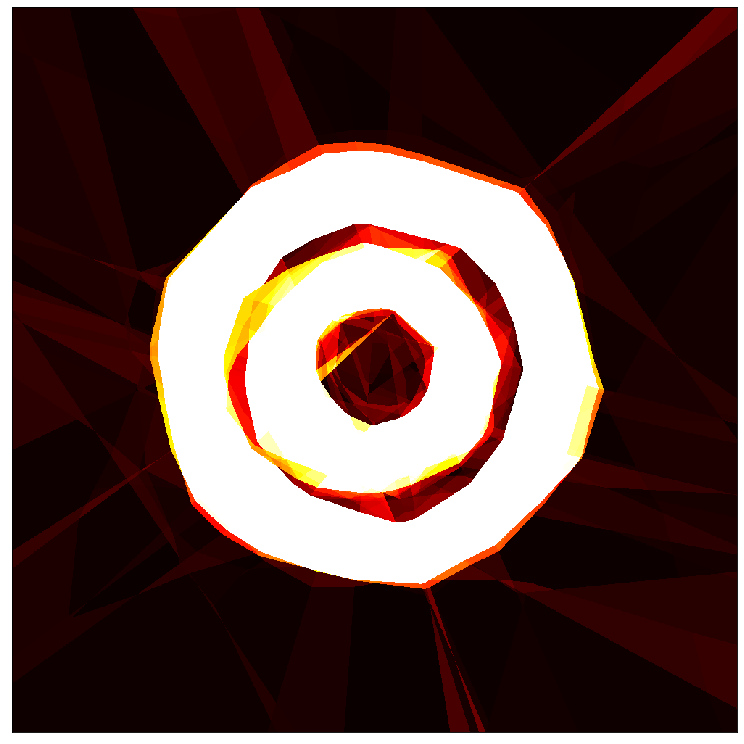

In [85]:
visualize_gradients(f_alp_l01_ip1)

In [86]:
# ALP \lambda 1 ip 1
f_alp_l1_ip1 = nn.Sequential(
    nn.Linear(2, 20),
    nn.ReLU(),
    nn.Linear(20, 40),
    nn.ReLU(),
    nn.Linear(40, 20),
    nn.ReLU(),
    nn.Linear(20, 1)
).cuda()

optimizer = torch.optim.Adam(f_alp_l1_ip1.parameters())

alr = ALR(
    d_X=lambda x, x_hat: torch.norm(x - x_hat, p=2, dim=1, keepdim=True), 
    d_Y=lambda y, y_hat: torch.abs(y - y_hat), 
    eps_min=1e-6, 
    eps_max=1e-5,
    xi=1e-1, 
    ip=1, 
    K=1
)

lambda_alp = 1

t = tqdm(iter(dataloader))
for step, batch in enumerate(t):
    x, y, x_reg = upload(batch[0]), upload(batch[1]), upload(batch[2]).view(-1, 2)

    optimizer.zero_grad()
    
    x_hat = alr.get_adversarial_perturbations(
        f=f_alp_l1_ip1, x=x_reg
    )
    
    y_hat = f_alp_l1_ip1(x)
    loss = F.mse_loss(y_hat, y)
    
    alp, lip_ratio, x_diff, y_diff, alp_count = alr.get_alp(
        x=x_reg, x_hat=x_hat, y=f_alp_l1_ip1(x_reg), y_hat=f_alp_l1_ip1(x_hat)
    )
    
    alp_loss = lambda_alp * (alp ** 2).mean()
    
    (loss + alp_loss).backward()
    optimizer.step()
    t.set_description(f"loss={loss.item()} count={alp_count} lip={lip_ratio.max().item()}")
    

visualize range [1.1026859283447266e-05, 1.0863101482391357] mean 0.05170820653438568


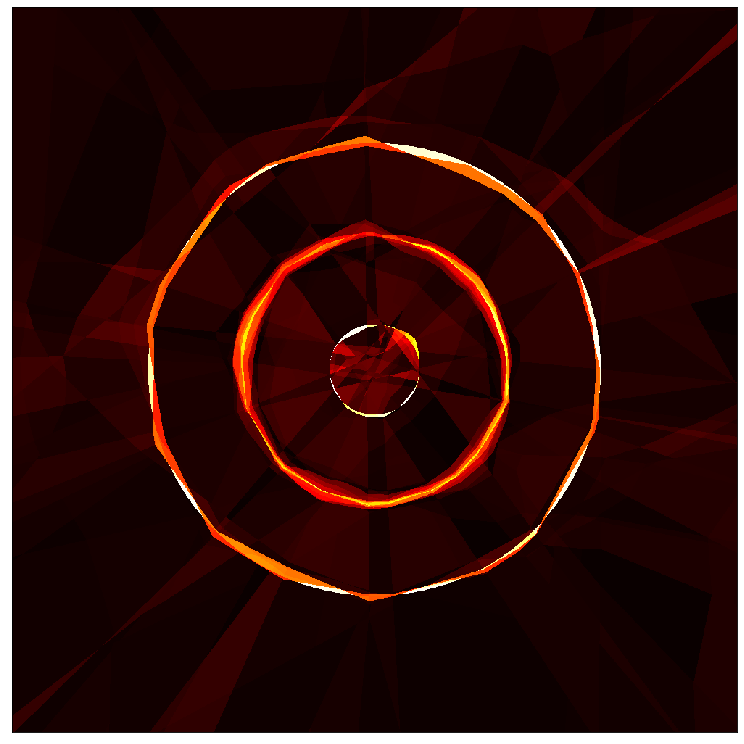

In [87]:
visualize_gradient_error(f_alp_l1_ip1)

visualize range [-0.022258684039115906, 1.0184462070465088] mean 0.838189423084259


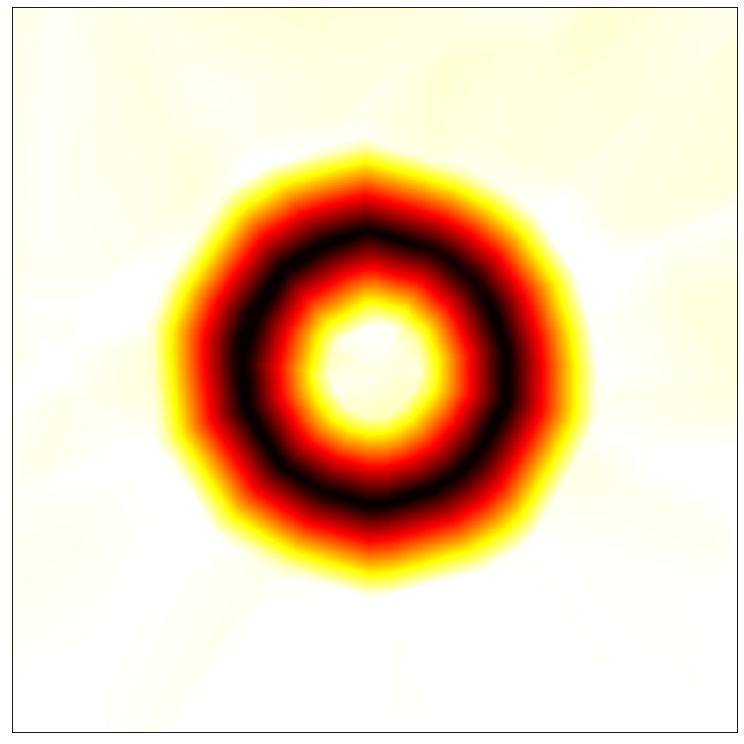

In [88]:
visualize_map(f_alp_l1_ip1)

visualize range [5.960464477539063e-08, 0.5961253643035889] mean 0.08155515044927597


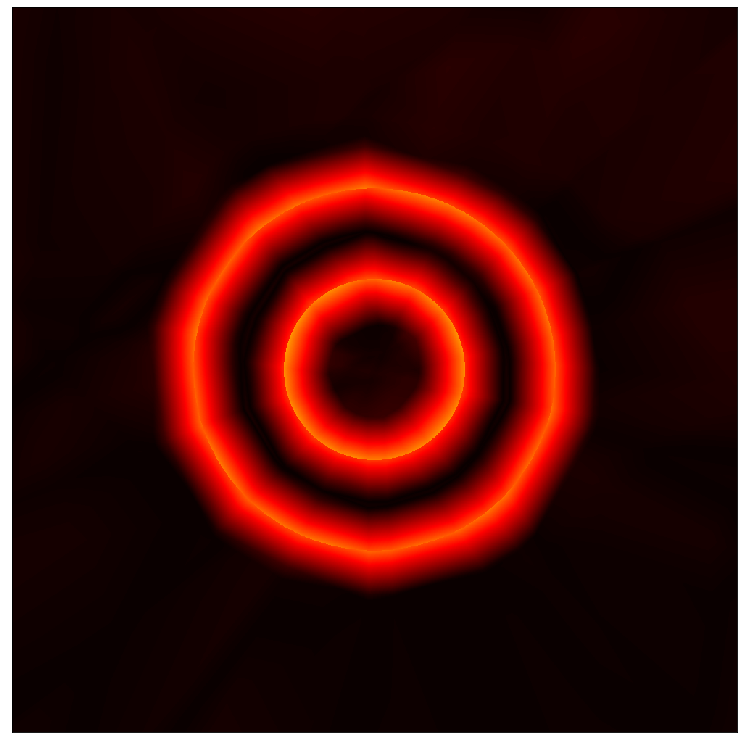

In [89]:
visualize_error(f_alp_l1_ip1)

visualize range [0.0013434740249067545, 1.1062318086624146] mean 0.3067913353443146


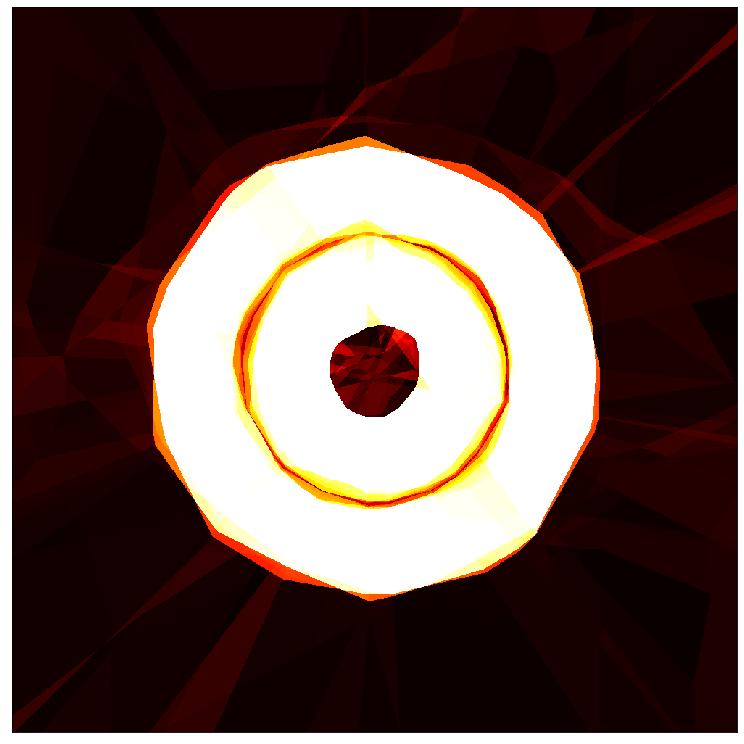

In [90]:
visualize_gradients(f_alp_l1_ip1)

In [91]:
# ALP \lambda 10 ip 1
f_alp_l10_ip1 = nn.Sequential(
    nn.Linear(2, 20),
    nn.ReLU(),
    nn.Linear(20, 40),
    nn.ReLU(),
    nn.Linear(40, 20),
    nn.ReLU(),
    nn.Linear(20, 1)
).cuda()

optimizer = torch.optim.Adam(f_alp_l10_ip1.parameters())

alr = ALR(
    d_X=lambda x, x_hat: torch.norm(x - x_hat, p=2, dim=1, keepdim=True), 
    d_Y=lambda y, y_hat: torch.abs(y - y_hat), 
    eps_min=1e-6, 
    eps_max=1e-5,
    xi=1e-1, 
    ip=1, 
    K=1
)

lambda_alp = 10

t = tqdm(iter(dataloader))
for step, batch in enumerate(t):
    x, y, x_reg = upload(batch[0]), upload(batch[1]), upload(batch[2]).view(-1, 2)

    optimizer.zero_grad()
    
    x_hat = alr.get_adversarial_perturbations(
        f=f_alp_l10_ip1, x=x_reg
    )
    
    y_hat = f_alp_l10_ip1(x)
    loss = F.mse_loss(y_hat, y)
    
    alp, lip_ratio, x_diff, y_diff, alp_count = alr.get_alp(
        x=x_reg, x_hat=x_hat, y=f_alp_l10_ip1(x_reg), y_hat=f_alp_l10_ip1(x_hat)
    )
    
    alp_loss = lambda_alp * (alp ** 2).mean()
    
    (loss + alp_loss).backward()
    optimizer.step()
    t.set_description(f"loss={loss.item()} count={alp_count} lip={lip_ratio.max().item()}")
    

visualize range [6.711483001708984e-05, 0.9997431635856628] mean 0.048967860639095306


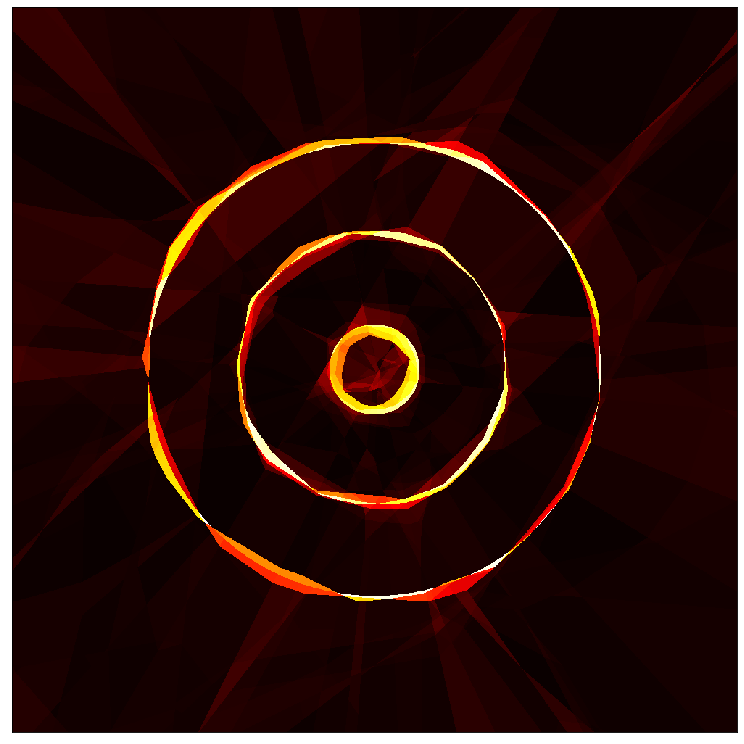

In [92]:
visualize_gradient_error(f_alp_l10_ip1)

visualize range [-0.013668444007635117, 1.0557210445404053] mean 0.8469780087471008


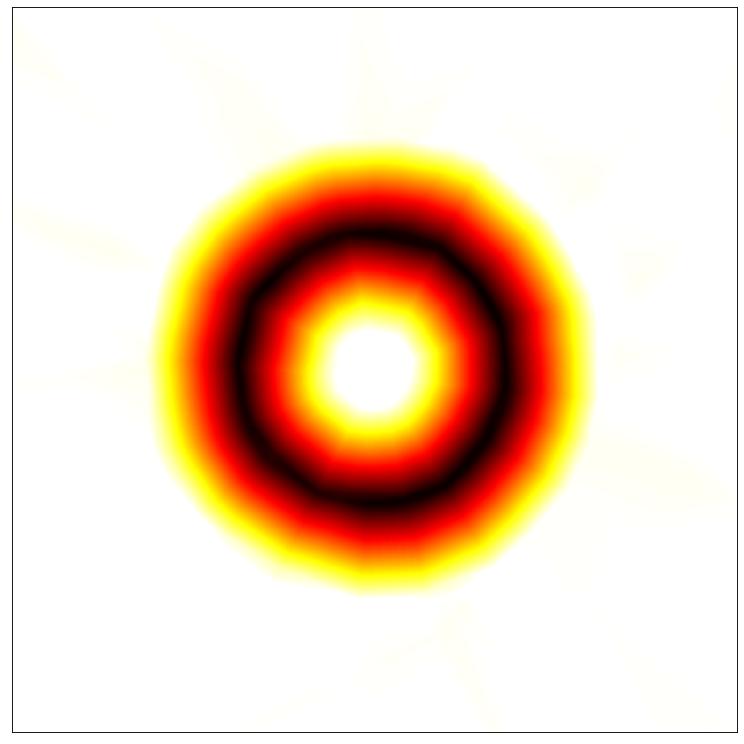

In [93]:
visualize_map(f_alp_l10_ip1)

visualize range [5.960464477539063e-08, 0.5788540840148926] mean 0.07947549968957901


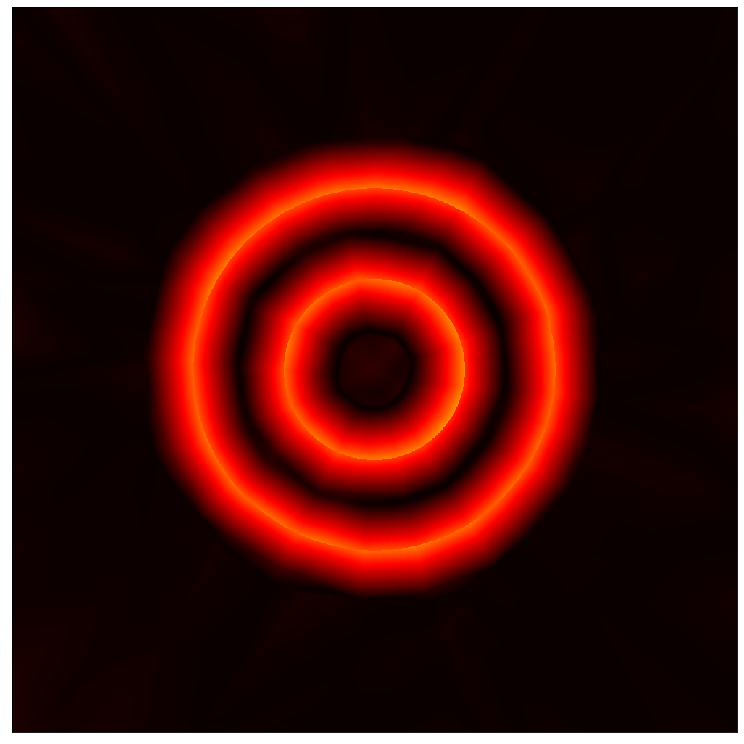

In [94]:
visualize_error(f_alp_l10_ip1)

visualize range [0.001640063477680087, 1.0461347103118896] mean 0.3078386187553406


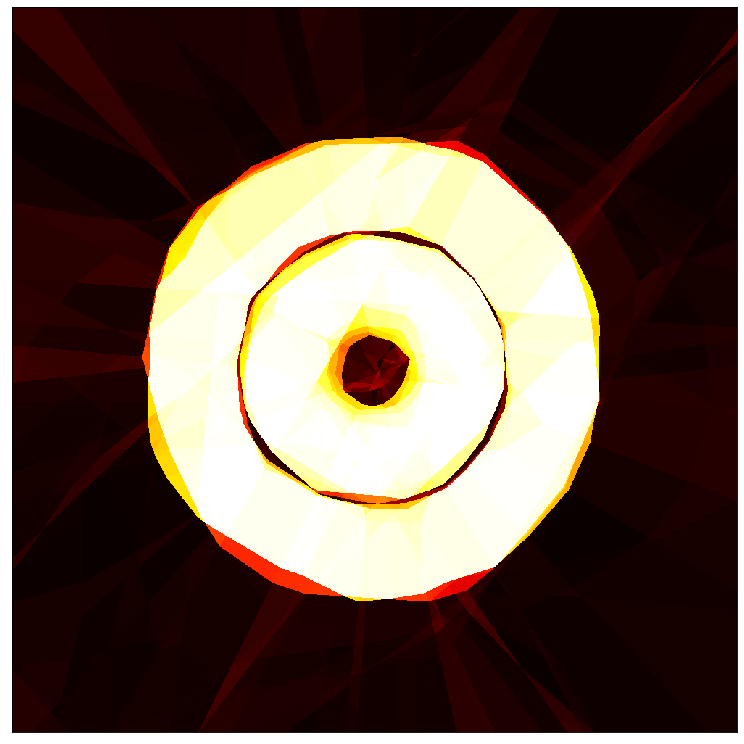

In [95]:
visualize_gradients(f_alp_l10_ip1)

In [96]:
# ALP \lambda 0.1 ip 5
f_alp_l01_ip5 = nn.Sequential(
    nn.Linear(2, 20),
    nn.ReLU(),
    nn.Linear(20, 40),
    nn.ReLU(),
    nn.Linear(40, 20),
    nn.ReLU(),
    nn.Linear(20, 1)
).cuda()

optimizer = torch.optim.Adam(f_alp_l01_ip5.parameters())

alr = ALR(
    d_X=lambda x, x_hat: torch.norm(x - x_hat, p=2, dim=1, keepdim=True), 
    d_Y=lambda y, y_hat: torch.abs(y - y_hat), 
    eps_min=1e-6, 
    eps_max=1e-5,
    xi=1e-1, 
    ip=5, 
    K=1
)

lambda_alp = 0.1

t = tqdm(iter(dataloader))
for step, batch in enumerate(t):
    x, y, x_reg = upload(batch[0]), upload(batch[1]), upload(batch[2]).view(-1, 2)

    optimizer.zero_grad()
    
    x_hat = alr.get_adversarial_perturbations(
        f=f_alp_l01_ip5, x=x_reg
    )
    
    y_hat = f_alp_l01_ip5(x)
    loss = F.mse_loss(y_hat, y)
    
    alp, lip_ratio, x_diff, y_diff, alp_count = alr.get_alp(
        x=x_reg, x_hat=x_hat, y=f_alp_l01_ip5(x_reg), y_hat=f_alp_l01_ip5(x_hat)
    )
    
    alp_loss = lambda_alp * (alp ** 2).mean()
    
    (loss + alp_loss).backward()
    optimizer.step()
    t.set_description(f"loss={loss.item()} count={alp_count} lip={lip_ratio.max().item()}")
    

visualize range [0.00018131732940673828, 0.9966684579849243] mean 0.1274641454219818


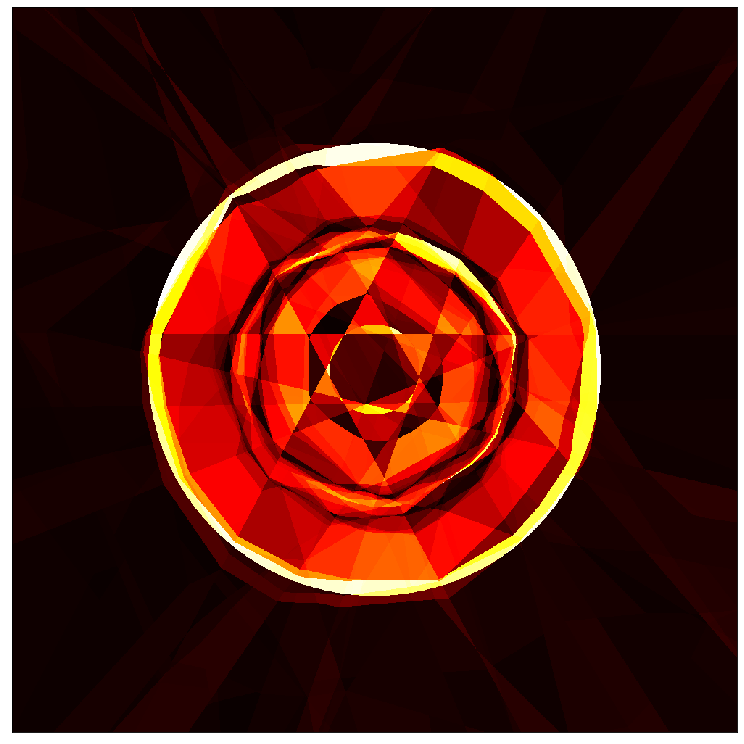

In [97]:
visualize_gradient_error(f_alp_l01_ip5)

visualize range [-0.07445584237575531, 1.1032956838607788] mean 0.8642470240592957


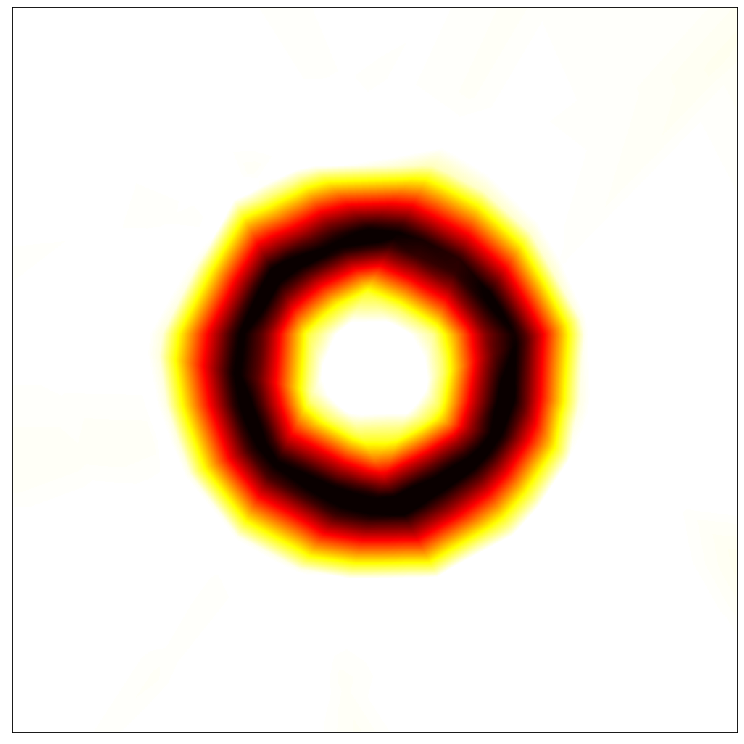

In [98]:
visualize_map(f_alp_l01_ip5)

visualize range [0.0, 0.6146270036697388] mean 0.06205762177705765


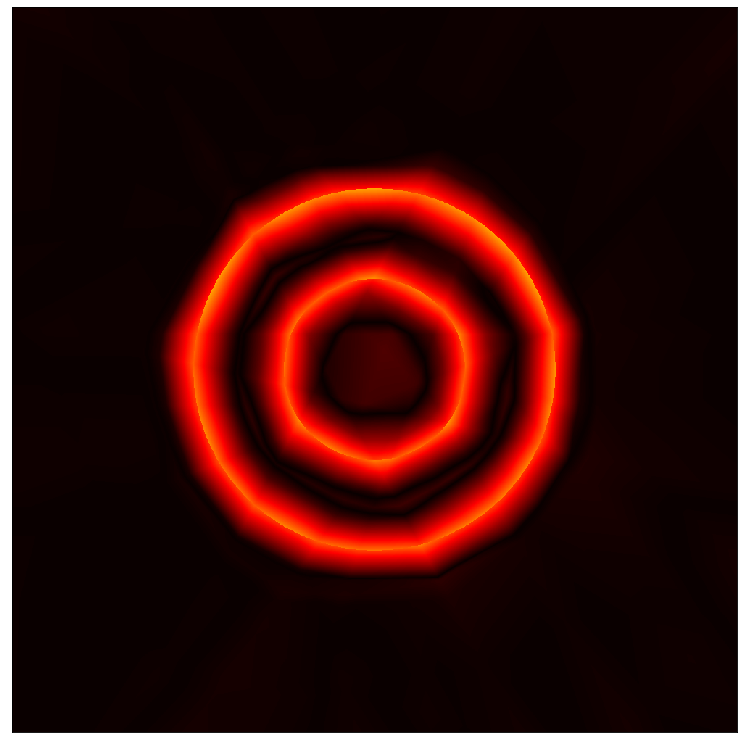

In [99]:
visualize_error(f_alp_l01_ip5)

visualize range [0.0010620843386277556, 1.6430342197418213] mean 0.3227660059928894


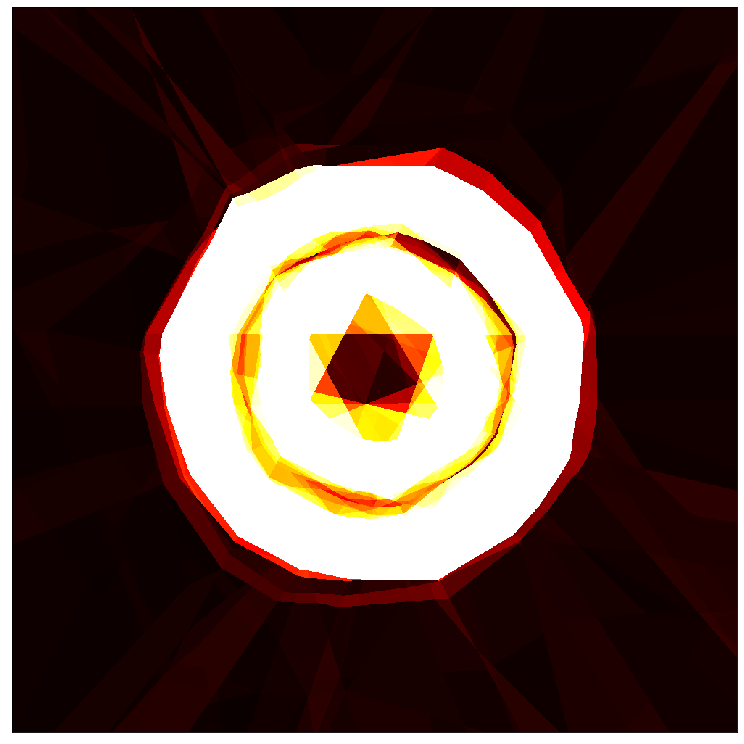

In [100]:
visualize_gradients(f_alp_l01_ip5)

In [112]:
# ALP \lambda 1 ip 5
f_alp_l1_ip5 = nn.Sequential(
    nn.Linear(2, 20),
    nn.ReLU(),
    nn.Linear(20, 40),
    nn.ReLU(),
    nn.Linear(40, 20),
    nn.ReLU(),
    nn.Linear(20, 1)
).cuda()

optimizer = torch.optim.Adam(f_alp_l1_ip5.parameters())

alr = ALR(
    d_X=lambda x, x_hat: torch.norm(x - x_hat, p=2, dim=1, keepdim=True), 
    d_Y=lambda y, y_hat: torch.abs(y - y_hat), 
    eps_min=1e-6, 
    eps_max=1e-5,
    xi=1e-1, 
    ip=5, 
    K=1
)

lambda_alp = 1

t = tqdm(iter(dataloader))
for step, batch in enumerate(t):
    x, y, x_reg = upload(batch[0]), upload(batch[1]), upload(batch[2]).view(-1, 2)

    optimizer.zero_grad()
    
    x_hat = alr.get_adversarial_perturbations(
        f=f_alp_l1_ip5, x=x_reg
    )
    
    y_hat = f_alp_l1_ip5(x)
    loss = F.mse_loss(y_hat, y)
    
    alp, lip_ratio, x_diff, y_diff, alp_count = alr.get_alp(
        x=x_reg, x_hat=x_hat, y=f_alp_l1_ip5(x_reg), y_hat=f_alp_l1_ip5(x_hat)
    )
    
    alp_loss = lambda_alp * (alp ** 2).mean()
    
    (loss + alp_loss).backward()
    optimizer.step()
    t.set_description(f"loss={loss.item()} count={alp_count} lip={lip_ratio.max().item()}")
    

visualize range [1.2099742889404297e-05, 1.094854474067688] mean 0.046963054686784744


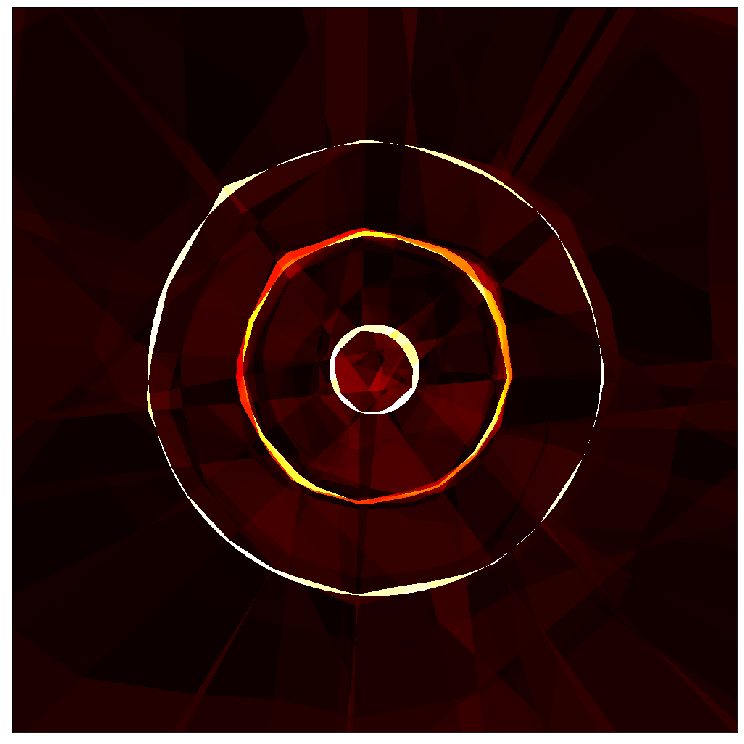

In [113]:
visualize_gradient_error(f_alp_l1_ip5)

visualize range [-0.04386265575885773, 1.0467084646224976] mean 0.8593056797981262


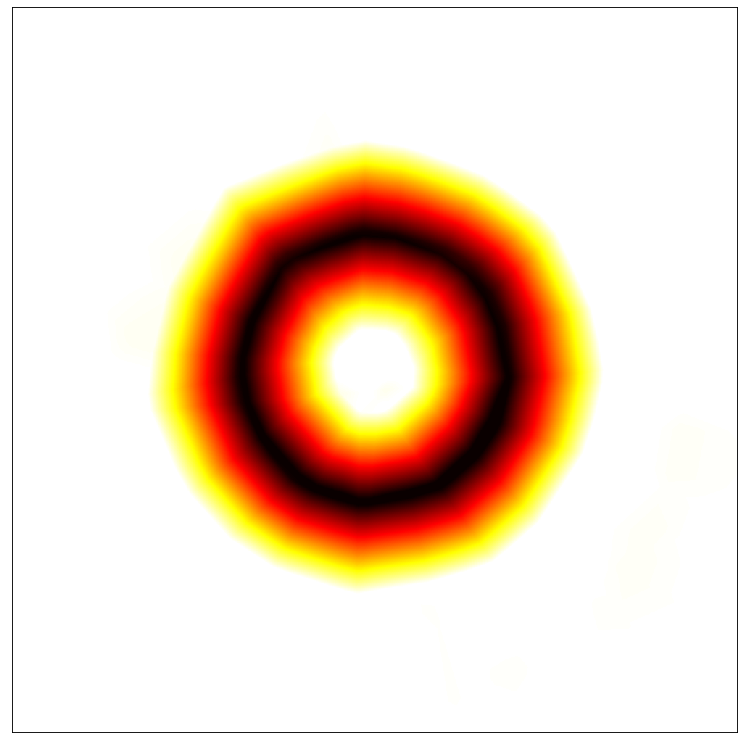

In [114]:
visualize_map(f_alp_l1_ip5)

visualize range [1.1920928955078125e-07, 0.6059351563453674] mean 0.079838827252388


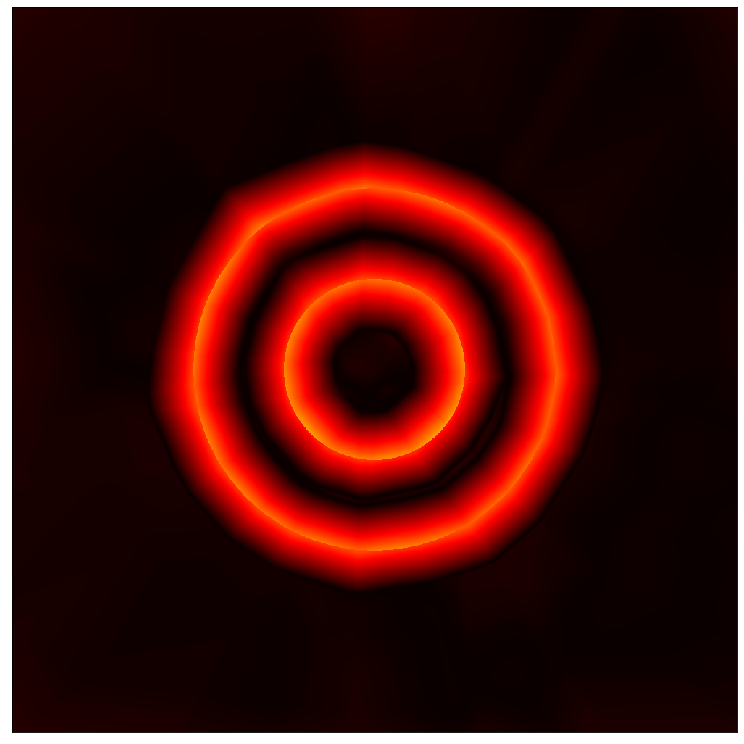

In [115]:
visualize_error(f_alp_l1_ip5)

visualize range [0.001925383461639285, 1.1298754215240479] mean 0.3107109069824219


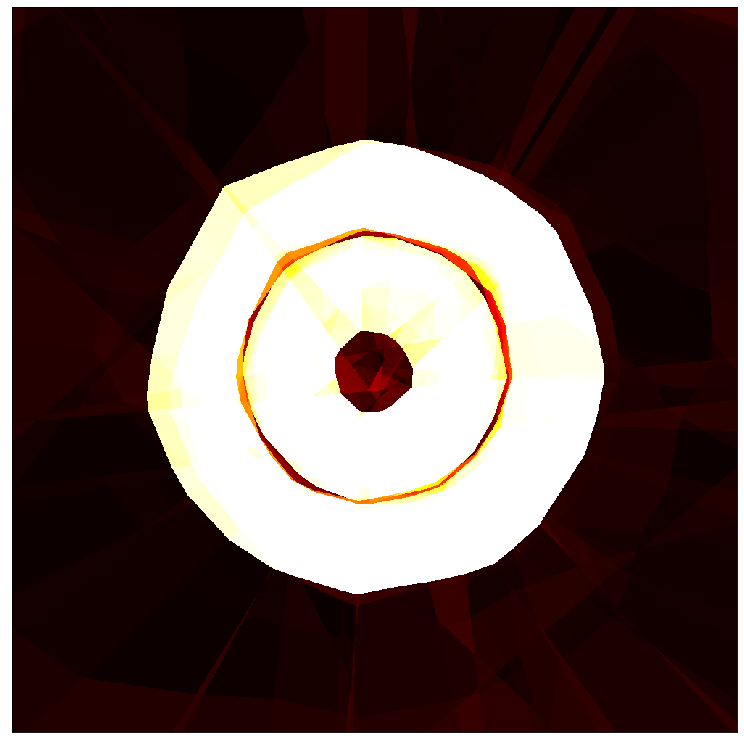

In [116]:
visualize_gradients(f_alp_l1_ip5)

In [106]:
# ALP \lambda 10 ip 5
f_alp_l10_ip5 = nn.Sequential(
    nn.Linear(2, 20),
    nn.ReLU(),
    nn.Linear(20, 40),
    nn.ReLU(),
    nn.Linear(40, 20),
    nn.ReLU(),
    nn.Linear(20, 1)
).cuda()

optimizer = torch.optim.Adam(f_alp_l10_ip5.parameters())

alr = ALR(
    d_X=lambda x, x_hat: torch.norm(x - x_hat, p=2, dim=1, keepdim=True), 
    d_Y=lambda y, y_hat: torch.abs(y - y_hat), 
    eps_min=1e-6, 
    eps_max=1e-5,
    xi=1e-1, 
    ip=5, 
    K=1
)

lambda_alp = 10

t = tqdm(iter(dataloader))
for step, batch in enumerate(t):
    x, y, x_reg = upload(batch[0]), upload(batch[1]), upload(batch[2]).view(-1, 2)

    optimizer.zero_grad()
    
    x_hat = alr.get_adversarial_perturbations(
        f=f_alp_l10_ip5, x=x_reg
    )
    
    y_hat = f_alp_l10_ip5(x)
    loss = F.mse_loss(y_hat, y)
    
    alp, lip_ratio, x_diff, y_diff, alp_count = alr.get_alp(
        x=x_reg, x_hat=x_hat, y=f_alp_l10_ip5(x_reg), y_hat=f_alp_l10_ip5(x_hat)
    )
    
    alp_loss = lambda_alp * (alp ** 2).mean()
    
    (loss + alp_loss).backward()
    optimizer.step()
    t.set_description(f"loss={loss.item()} count={alp_count} lip={lip_ratio.max().item()}")
    

visualize range [0.00047647953033447266, 0.9962602853775024] mean 0.04479915648698807


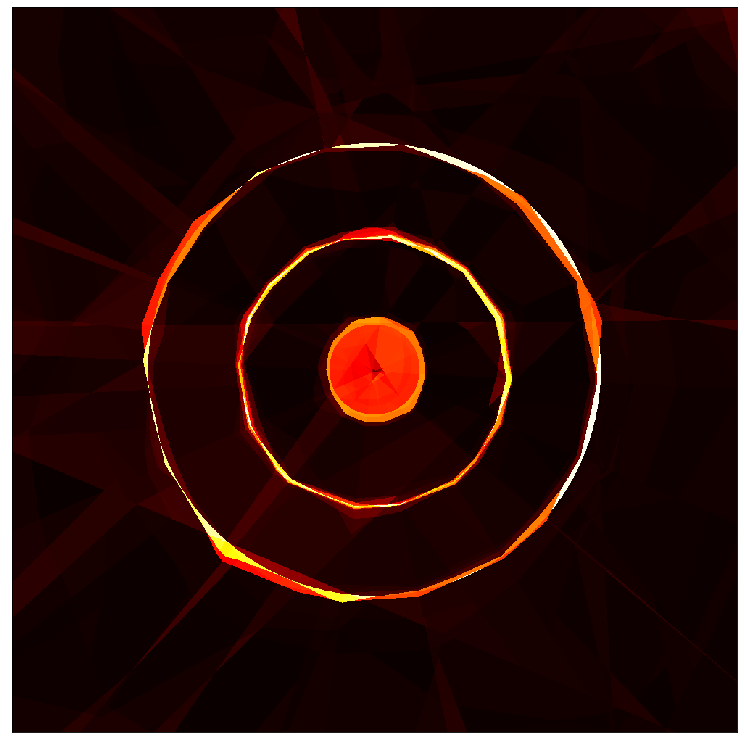

In [107]:
visualize_gradient_error(f_alp_l10_ip5)

visualize range [0.03838861733675003, 1.1453889608383179] mean 0.8698650002479553


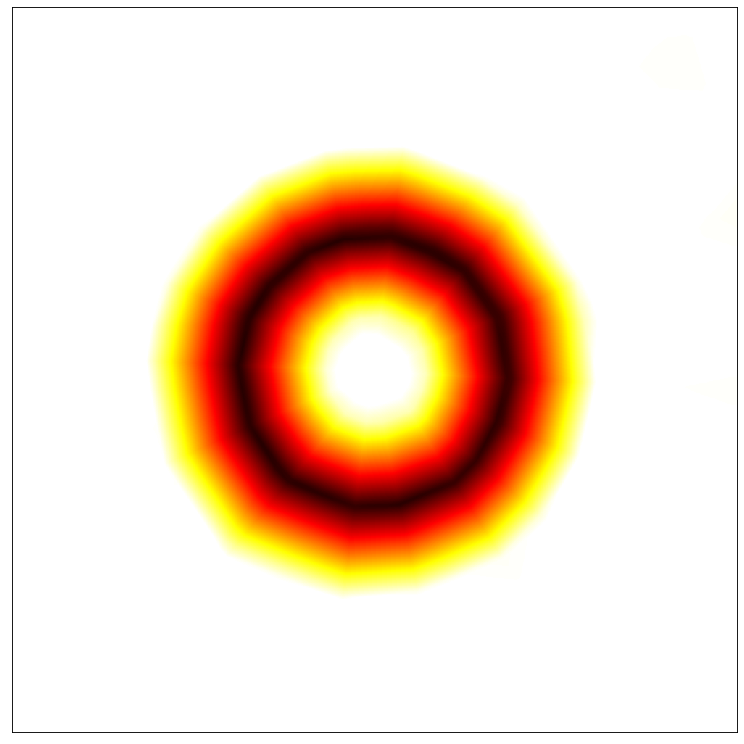

In [108]:
visualize_map(f_alp_l10_ip5)

visualize range [0.0, 0.5924708247184753] mean 0.08454550802707672


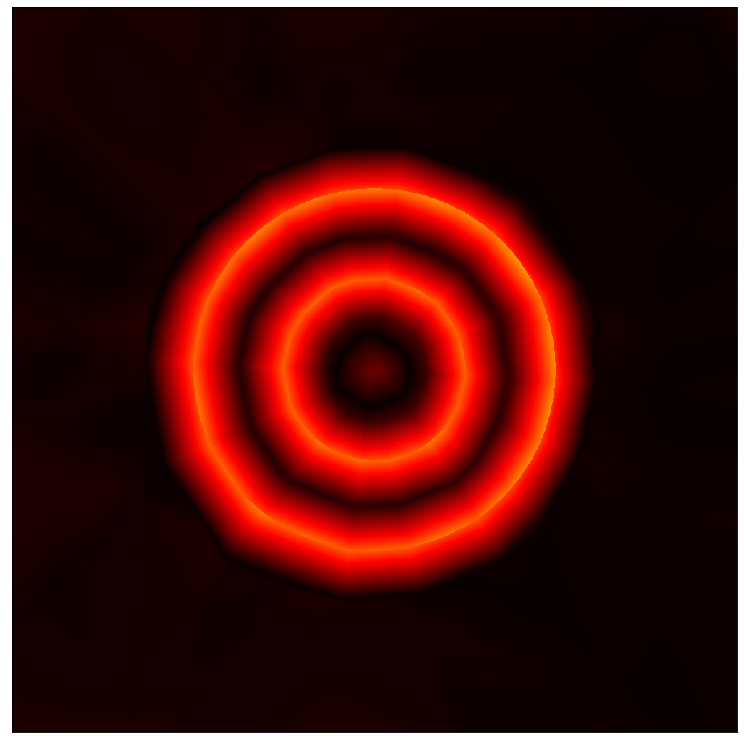

In [109]:
visualize_error(f_alp_l10_ip5)

visualize range [0.0011641306336969137, 1.0245624780654907] mean 0.2951536476612091


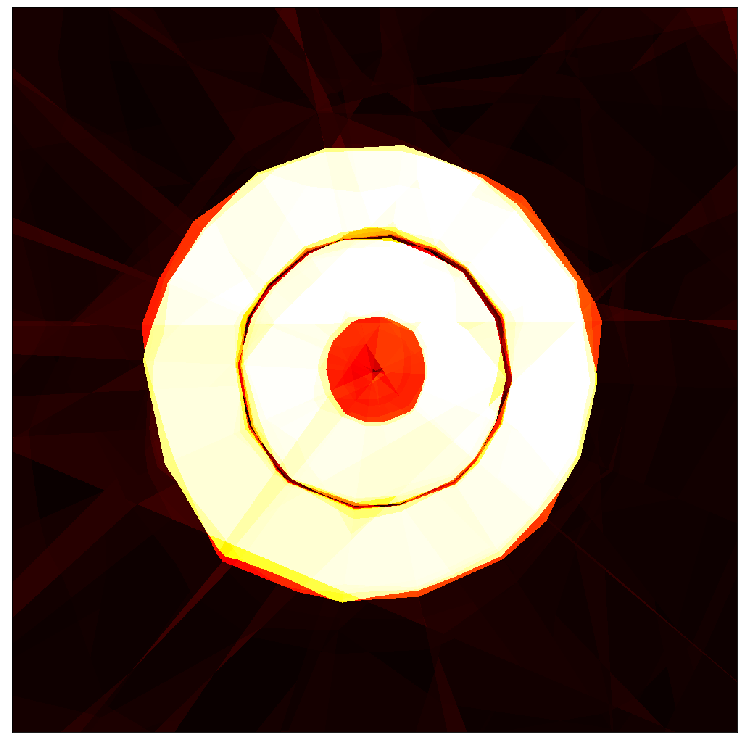

In [110]:
visualize_gradients(f_alp_l10_ip5)

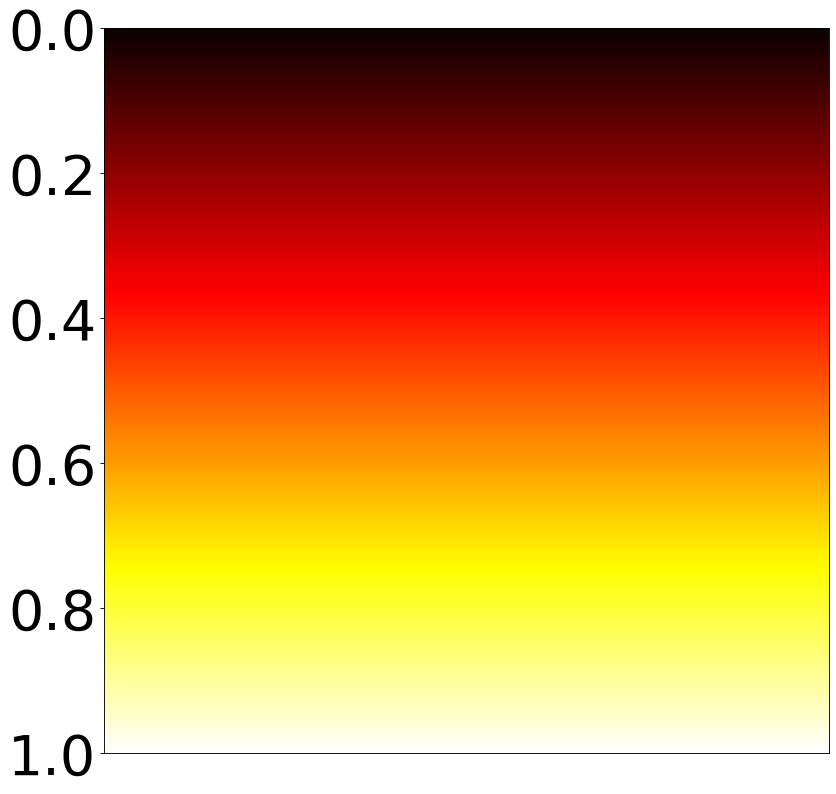

In [111]:
x = torch.linspace(start=0, end=1, steps=dim).unsqueeze(1).repeat(1, dim)
vmin=0
vmax=1
pp.figure(num=None, figsize=(12, 12), dpi=80)
fig = pp.imshow(
    x, cmap='hot', interpolation='nearest', 
    extent=(1, 0, 1, 0), vmin=vmin, vmax=vmax
)
fig.axes.get_xaxis().set_visible(False)
# fig.axes.get_yaxis().set_visible(False)
# print(dir(fig.axes.get_yaxis()))
for tick in fig.axes.get_yaxis().get_major_ticks():
    tick.label.set_fontsize(50) 
pp.show()